In [170]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics, layers, models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
tf.get_logger().setLevel('INFO')
from keras import backend as K

import os
from os import listdir
from PIL import Image


from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from xgboost import XGBClassifier




from vit_keras import vit, utils, visualize




import dashtable
import time

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [169]:
## Might need to install SMOTE. After install, I needed to close anaconda/jupyter notebook and reopen it for it to
## work :) - Kara
##Also import opencv-python for image augmentation- Negin
# import sys
# !{sys.executable} -m pip install imbalanced-learn
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install vit-keras
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install pydot
# !{sys.executable} -m pip install --upgrade dash
# !{sys.executable} -m pip install --upgrade typing_extensions
# !{sys.executable} -m pip install dashtable

  Created wheel for dashtable: filename=dashtable-1.4.5-py3-none-any.whl size=42340 sha256=7bc571bb71f154d3ca560298170c8a7edc049029baec1b776c05d35eb3b5dd4f
  Stored in directory: /Users/karachristensen/Library/Caches/pip/wheels/d0/66/cd/0ecede649df6c6811970ef15336033176f64b093216276c194
Successfully built dashtable


In [3]:
carrigan = False

### Load Data

In [4]:
if carrigan:
  df = pd.read_csv('/content/drive/MyDrive/Kidney Project Data/kidneyData.csv')
else:
  df = pd.read_csv('KidneyImages/kidneyData.csv')

In [5]:
display(df)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [6]:
newsize = (256, 256)

In [7]:
## Read in all images
# First, read in all cyst images

cystImages = []

# Get the correct folder of images
folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"

for images in os.listdir(folder_dir): # For each item in the folder
    if (images.endswith(".jpg")): # If it is a jpg
        image = Image.open(folder_dir + '/' + images) # Open the image
        image = image.resize(newsize) # Resize it to 256x256
        npImage = np.asarray(image) # Turn it into an array
        reshapedImage = npImage[:, :, 0] # Get rid of the last two color values (since it is black and white)
        cystImages.append({'image_id': images[:-4], 'image': reshapedImage}) # Add the information to the dictionary

In [8]:
# Then all normal images
normalImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        normalImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [9]:
# Then all stone images
stoneImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        stoneImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [10]:
# Then all tumor images
tumorImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        tumorImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [11]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

## NEW PREPROCESSING FLOW STARTS HERE

In [12]:
## Preprocess the cyst images
# Sort them by image number
cysts = pd.DataFrame(cystImages)
cysts['number'] = cysts['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
cysts = cysts.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
cystsWithLabel = cysts.merge(df, how = 'inner', on = 'image_id')
cystsWithLabel = cystsWithLabel[['image', 'target']]
cystX = cystsWithLabel['image'].to_numpy()
cysty = cystsWithLabel['target'].to_numpy()
print(len(cystX))

# Reshape the array
cystX = np.array([x for x in cystX])
nsamples, nx, ny = cystX.shape
cystX = cystX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
cystX_and_y = np.column_stack((cystX, cysty))
cystX_and_y = pd.DataFrame(cystX_and_y)
cystX_and_y = cystX_and_y.drop_duplicates()
cystX = cystX_and_y.iloc[:,:-1].to_numpy()
cysty = cystX_and_y.iloc[:,-1:].to_numpy()
print(len(cystX))

3709
3284


In [13]:
## Preprocess the stone images
# Sort them by image number
stones = pd.DataFrame(stoneImages)
stones['number'] = stones['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
stones = stones.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
stonesWithLabel = stones.merge(df, how = 'inner', on = 'image_id')
stonesWithLabel = stonesWithLabel[['image', 'target']]
stoneX = stonesWithLabel['image'].to_numpy()
stoney = stonesWithLabel['target'].to_numpy()
print(len(stoneX))

# Reshape the array
stoneX = np.array([x for x in stoneX])
nsamples, nx, ny = stoneX.shape
stoneX = stoneX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
stoneX_and_y = np.column_stack((stoneX, stoney))
stoneX_and_y = pd.DataFrame(stoneX_and_y)
stoneX_and_y = stoneX_and_y.drop_duplicates()
stoneX = stoneX_and_y.iloc[:,:-1].to_numpy()
stoney = stoneX_and_y.iloc[:,-1:].to_numpy()
print(len(stoneX))

1377
1360


In [14]:
## Preprocess the normal images
# Sort them by image number
norms = pd.DataFrame(normalImages)
norms['number'] = norms['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
norms = norms.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
normsWithLabel = norms.merge(df, how = 'inner', on = 'image_id')
normsWithLabel = normsWithLabel[['image', 'target']]
normsX = normsWithLabel['image'].to_numpy()
normsy = normsWithLabel['target'].to_numpy()
print(len(normsX))

# Reshape the array
normsX = np.array([x for x in normsX])
nsamples, nx, ny = normsX.shape
normsX = normsX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
normsX_and_y = np.column_stack((normsX, normsy))
normsX_and_y = pd.DataFrame(normsX_and_y)
normsX_and_y = normsX_and_y.drop_duplicates()
normsX = normsX_and_y.iloc[:,:-1].to_numpy()
normsy = normsX_and_y.iloc[:,-1:].to_numpy()
print(len(normsX))

5077
5002


In [15]:
## Preprocess the tumor images
# Sort them by image number
tumor = pd.DataFrame(tumorImages)
tumor['number'] = tumor['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
tumor = tumor.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
tumorWithLabel = tumor.merge(df, how = 'inner', on = 'image_id')
tumorWithLabel = tumorWithLabel[['image', 'target']]
tumorX = tumorWithLabel['image'].to_numpy()
tumory = tumorWithLabel['target'].to_numpy()
print(len(tumorX))

# Reshape the array
tumorX = np.array([x for x in tumorX])
nsamples, nx, ny = tumorX.shape
tumorX = tumorX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
tumorX_and_y = np.column_stack((tumorX, tumory))
tumorX_and_y = pd.DataFrame(tumorX_and_y)
tumorX_and_y = tumorX_and_y.drop_duplicates()
tumorX = tumorX_and_y.iloc[:,:-1].to_numpy()
tumory = tumorX_and_y.iloc[:,-1:].to_numpy()
print(len(tumorX))

2283
2283


In [16]:
# Split into train, validation, and test sets
cyst60 = int(np.floor(cystX.shape[0]*0.6))
cyst20 = int(np.floor(cystX.shape[0]*0.2))
stone60 = int(np.floor(stoneX.shape[0]*0.6))
stone20 = int(np.floor(stoneX.shape[0]*0.2))
norm60 = int(np.floor(normsX.shape[0]*0.6))
norm20 = int(np.floor(normsX.shape[0]*0.2))
tumor60 = int(np.floor(tumorX.shape[0]*0.6))
tumor20 = int(np.floor(tumorX.shape[0]*0.2))

cystXtrain = cystX[:cyst60]
cystXval = cystX[cyst60:cyst60+cyst20]
cystXtest = cystX[cyst60+cyst20:]
cystytrain = cysty[:cyst60]
cystyval = cysty[cyst60:cyst60+cyst20]
cystytest = cysty[cyst60+cyst20:]

stoneXtrain = stoneX[:stone60]
stoneXval = stoneX[stone60:stone60+stone20]
stoneXtest = stoneX[stone60+stone20:]
stoneytrain = stoney[:stone60]
stoneyval = stoney[stone60:stone60+stone20]
stoneytest = stoney[stone60+stone20:]

normXtrain = normsX[:norm60]
normXval = normsX[norm60:norm60+norm20]
normXtest = normsX[norm60+norm20:]
normytrain = normsy[:norm60]
normyval = normsy[norm60:norm60+norm20]
normytest = normsy[norm60+norm20:]

tumorXtrain = tumorX[:tumor60]
tumorXval = tumorX[tumor60:tumor60+tumor20]
tumorXtest = tumorX[tumor60+tumor20:]
tumorytrain = tumory[:tumor60]
tumoryval = tumory[tumor60:tumor60+tumor20]
tumorytest = tumory[tumor60+tumor20:]


In [17]:
X_train_new = np.concatenate((cystXtrain, stoneXtrain, normXtrain, tumorXtrain))
X_val_new = np.concatenate((cystXval, stoneXval, normXval, tumorXval))
X_test_new = np.concatenate((cystXtest, stoneXtest, normXtest, tumorXtest))
y_train_new = np.concatenate((cystytrain, stoneytrain, normytrain, tumorytrain))
y_val_new = np.concatenate((cystyval, stoneyval, normyval, tumoryval))
y_test_new = np.concatenate((cystytest, stoneytest, normytest, tumorytest))
print(X_train_new.shape, X_val_new.shape, X_test_new.shape)
print(y_train_new.shape, y_val_new.shape, y_test_new.shape)

(7156, 65536) (2384, 65536) (2389, 65536)
(7156, 1) (2384, 1) (2389, 1)


Training Set


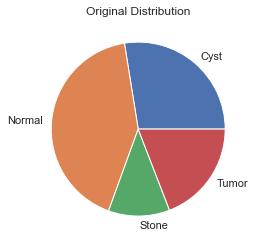

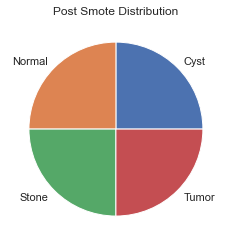

In [18]:
# SMOTE to balance classes

# Original class distribution
print('Training Set')
unique, counts = np.unique(y_train_new, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
XtrainsmoteNew, ytrainsmoteNew = oversample.fit_resample(X_train_new, y_train_new)


# Updated class distribution
uniquesmote, countssmote = np.unique(ytrainsmoteNew, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [19]:
np.random.seed(42)
indices = np.arange(XtrainsmoteNew.shape[0])
shuffled_indices = np.random.permutation(indices)
X_trainshuf_new = XtrainsmoteNew[shuffled_indices]
y_trainshuf_new = ytrainsmoteNew[shuffled_indices]
print(X_train_new.shape)
print(X_trainshuf_new.shape)
print(y_trainshuf_new.shape)

indices = np.arange(X_val_new.shape[0])
shuffled_indices = np.random.permutation(indices)
X_valshuf_new = X_val_new[shuffled_indices]
y_valshuf_new = y_val_new[shuffled_indices]
print(X_val_new.shape)
print(X_valshuf_new.shape)
print(y_valshuf_new.shape)


indices = np.arange(X_test_new.shape[0])
shuffled_indices = np.random.permutation(indices)
X_testshuf_new = X_test_new[shuffled_indices]
y_testshuf_new = y_test_new[shuffled_indices]
print(X_test_new.shape)
print(X_testshuf_new.shape)
print(y_testshuf_new.shape)

(7156, 65536)
(12004, 65536)
(12004,)
(2384, 65536)
(2384, 65536)
(2384, 1)
(2389, 65536)
(2389, 65536)
(2389, 1)


## OLD PREPROCESSING FLOW BELOW

In [ ]:
# Concatenate all list of images, and turn into a data frame

allImages = cystImages + stoneImages + normalImages + tumorImages

imgs = pd.DataFrame(allImages)

In [ ]:
imgs

In [ ]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

In [ ]:
# Merge with the other dataframe to get each image matched with its label
imgWithLabel = imgs.merge(df, how = 'inner', on = 'image_id')
imgWithLabel = imgWithLabel[['image', 'target']]

In [ ]:
X = imgWithLabel['image'].to_numpy()
y = imgWithLabel['target'].to_numpy()

In [ ]:
if carrigan:
  X = np.load('/content/drive/MyDrive/Kidney Project Data/X.npy', allow_pickle=True)
  y = np.load('/content/drive/MyDrive/Kidney Project Data/y.npy', allow_pickle=True)

### Drop Duplicates

In [ ]:
# Reshape/ unpack the array of images, then flatten it so it is prepared for smote
X = np.array([x for x in X])
print(X.shape)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
print(X.shape)

In [ ]:
X_and_y = np.column_stack((X, y))
print(X_and_y.shape)

In [ ]:
X_and_y = pd.DataFrame(X_and_y)
X_and_y = X_and_y.drop_duplicates()
print(X_and_y.shape)

In [ ]:
X = X_and_y.iloc[:,:-1].to_numpy()
y = X_and_y.iloc[:,-1:].to_numpy()
print(X.shape)
print(y.shape)

### Perform SMOTE

In [ ]:
# Divide by 255, keep as float32 data
# print(np.max(X))
# X = (X.astype(np.float32) / 255.0).astype(np.float32)
# print(np.max(X))

In [ ]:
# SMOTE to balance classes

# Original class distribution
unique, counts = np.unique(y, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X, y)


# Updated class distribution
uniquesmote, countssmote = np.unique(ysmote, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [ ]:
del X
del y
del X_and_y

### Shuffle & reshape the data

In [ ]:
np.random.seed(42)
indices = np.arange(Xsmote.shape[0])
shuffled_indices = np.random.permutation(indices)
Xshuffled = Xsmote[shuffled_indices]
yshuffled = ysmote[shuffled_indices]
print(Xshuffled.shape)

In [ ]:
del Xsmote
del ysmote

### Train and test split

In [ ]:
X_train_flat, X_test_flat, y_train, y_test = train_test_split(Xshuffled, yshuffled, test_size=0.2, random_state=1)

In [ ]:
# Create an intermediary validation set
X_train_flat, X_val_flat, y_train, y_val = train_test_split(X_train_flat, y_train, test_size=0.25, random_state=1)

In [ ]:
# Reshape the data to 4 dimensional data
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))

In [ ]:
del Xshuffled
del yshuffled

## HERE UPDATES OLD NAMES TO NEW NAMES
#### Start back here if skipping old processing flow

In [20]:
print(np.max(X_trainshuf_new))
X_trainrescale_new = (X_trainshuf_new.astype(np.float32) / 255.0).astype(np.float32)
X_valrescale_new = (X_valshuf_new.astype(np.float32) / 255.0).astype(np.float32)
X_testrescale_new = (X_testshuf_new.astype(np.float32) / 255.0).astype(np.float32)
print(np.max(X_testrescale_new))

255
1.0


In [141]:
X_train_flat = X_trainrescale_new
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
y_train = y_trainshuf_new

X_val_flat = X_valrescale_new
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))
y_val = y_valshuf_new
y_val = y_val.reshape((len(y_val), ))

X_test_flat = X_testrescale_new
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
y_test = y_testshuf_new
y_test = y_test.reshape((len(y_test), ))

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_flat.shape, X_val_flat.shape, X_test_flat.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(12004, 256, 256, 1) (2384, 256, 256, 1) (2389, 256, 256, 1)
(12004, 65536) (2384, 65536) (2389, 65536)
(12004,) (2384,) (2389,)


### Image Augmentation

In [22]:
# Create augmentation layers
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])


(256, 256, 1)


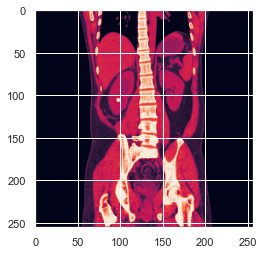

In [23]:
example_image = X_train[2]
print(example_image.shape)

plt.imshow(example_image)

In [25]:
plt.figure(figsize=(8, 7))
for i in range(6):
  aug_image = data_augmentation(example_image)
  ax = plt.subplot(2, 3, i + 1)
  plt.axis("off")

plt.show()

# Create Models

#### Create functions for class by class precision and recall

In [26]:
def recall(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    possible_postives = K.sum(true_c)
    return true_positives / (possible_postives + K.epsilon())


def precision(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    pred_positives = K.sum(pred_c)
    return true_positives / (pred_positives + K.epsilon())


In [27]:
def recall_c1(y_true, y_pred):
    return recall(y_true, y_pred, 0)

def precision_c1(y_true, y_pred):
    return precision(y_true, y_pred, 0)

def recall_c2(y_true, y_pred):
    return recall(y_true, y_pred, 1)

def precision_c2(y_true, y_pred):
    return precision(y_true, y_pred, 1)

def recall_c3(y_true, y_pred):
    return recall(y_true, y_pred, 2)

def precision_c3(y_true, y_pred):
    return precision(y_true, y_pred, 2)

def recall_c4(y_true, y_pred):
    return recall(y_true, y_pred, 3)

def precision_c4(y_true, y_pred):
    return precision(y_true, y_pred, 3)

In [42]:
def allClassPrecisionsandRecalls(y_true, y_pred):
#     RECALL: true positives/ true positives + false negatives
#     PRECISION: true positives/true positives + false positives
    truePositives = {0:0, 1:0, 2:0, 3:0}
    falsePositives = {0:0, 1:0, 2:0, 3:0}
    falseNegatives = {0:0, 1:0, 2:0, 3:0}
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            truePositives[y_true[i]] += 1
        else:
            falseNegatives[y_true[i]] += 1
            falsePositives[y_pred[i]] += 1
    
    precisions = [truePositives[i]/(truePositives[i] + falsePositives[i]) for i in range(4)]
    recalls = [truePositives[i]/(truePositives[i] + falseNegatives[i]) for i in range(4)]
    
    accuracy = sum([truePositives[i] for i in range(4)])/len(y_true)
    
    return accuracy, precisions, recalls
        

## Classical Machine Learning Models

### Model 1 - Multiclass Classifier

In [206]:
def build_multiclass_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """

    model = keras.Sequential([
        data_augmentation,
        keras.layers.Flatten(),
        keras.layers.Dense(units=n_classes, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    return model

In [207]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model1 = build_multiclass_model(4, 0.001)
numEpochs = 20

startTime = time.time()
history = model1.fit(
  x = X_train,
  y = y_train,
  epochs=numEpochs,
  batch_size=64,
  validation_data = (X_val, y_val),
  verbose=1)
endTime = time.time()

model1Time = (endTime - startTime)/60

Epoch 1/20
188/188 [==============================] - 17s 74ms/step - loss: 1.2893 - accuracy: 0.3795 - recall_c1: 0.2311 - precision_c1: 0.5565 - recall_c2: 0.5666 - precision_c2: 0.3390 - recall_c3: 0.3344 - precision_c3: 0.3658 - recall_c4: 0.3868 - precision_c4: 0.4390 - val_loss: 1.3729 - val_accuracy: 0.2441 - val_recall_c1: 0.3769 - val_precision_c1: 0.3339 - val_recall_c2: 0.2108 - val_precision_c2: 0.3601 - val_recall_c3: 0.2696 - val_precision_c3: 0.1697 - val_recall_c4: 0.1190 - val_precision_c4: 0.0943
Epoch 2/20
188/188 [==============================] - 12s 64ms/step - loss: 1.1725 - accuracy: 0.4963 - recall_c1: 0.3980 - precision_c1: 0.6192 - recall_c2: 0.6353 - precision_c2: 0.4333 - recall_c3: 0.4437 - precision_c3: 0.4993 - recall_c4: 0.5157 - precision_c4: 0.6071 - val_loss: 1.3203 - val_accuracy: 0.4077 - val_recall_c1: 0.2104 - val_precision_c1: 0.4058 - val_recall_c2: 0.7718 - val_precision_c2: 0.4812 - val_recall_c3: 0.1868 - val_precision_c3: 0.2002 - val_recal

188/188 [==============================] - 11s 60ms/step - loss: 0.8731 - accuracy: 0.6815 - recall_c1: 0.5730 - precision_c1: 0.7257 - recall_c2: 0.7173 - precision_c2: 0.6199 - recall_c3: 0.7199 - precision_c3: 0.6907 - recall_c4: 0.7159 - precision_c4: 0.7362 - val_loss: 1.4541 - val_accuracy: 0.4060 - val_recall_c1: 0.2080 - val_precision_c1: 0.4071 - val_recall_c2: 0.7550 - val_precision_c2: 0.5416 - val_recall_c3: 0.2254 - val_precision_c3: 0.1596 - val_recall_c4: 0.0217 - val_precision_c4: 0.0396
Epoch 13/20
188/188 [==============================] - 12s 63ms/step - loss: 0.8621 - accuracy: 0.6907 - recall_c1: 0.5850 - precision_c1: 0.7438 - recall_c2: 0.7218 - precision_c2: 0.6263 - recall_c3: 0.7280 - precision_c3: 0.7000 - recall_c4: 0.7240 - precision_c4: 0.7421 - val_loss: 1.5262 - val_accuracy: 0.3020 - val_recall_c1: 0.2341 - val_precision_c1: 0.3939 - val_recall_c2: 0.4501 - val_precision_c2: 0.4866 - val_recall_c3: 0.3023 - val_precision_c3: 0.1520 - val_recall_c4: 0.05

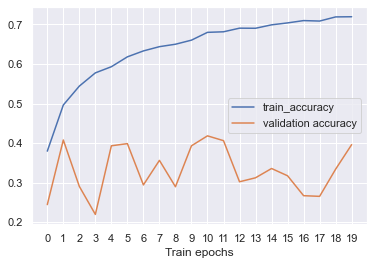

In [208]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [209]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.289336,0.379457,0.231061,0.556484,0.566613,0.338973,0.334415,0.365770,0.386759,0.439019,1.372942,0.244128,0.376913,0.333869,0.210806,0.360126,0.269578,0.169728,0.119027,0.094282
1,1.172454,0.496251,0.397957,0.619241,0.635292,0.433326,0.443719,0.499262,0.515747,0.607055,1.320265,0.407718,0.210361,0.405779,0.771826,0.481157,0.186796,0.200188,0.011705,0.036654
2,1.106929,0.544069,0.453059,0.625683,0.654261,0.473049,0.511832,0.550241,0.558840,0.646398,1.398786,0.290268,0.159573,0.343645,0.476542,0.441252,0.226803,0.245030,0.116564,0.074672
3,1.061934,0.577558,0.477179,0.639794,0.670237,0.505693,0.552130,0.601557,0.607735,0.665392,1.541931,0.219379,0.117127,0.382968,0.206102,0.381648,0.639217,0.156705,0.132732,0.111281
4,1.024707,0.593136,0.485789,0.637462,0.668590,0.525473,0.595767,0.624513,0.628875,0.679262,1.356405,0.393037,0.230503,0.435184,0.744929,0.481550,0.093696,0.218202,0.025779,0.032560
5,0.995604,0.618127,0.511304,0.662770,0.675317,0.554221,0.646745,0.658421,0.643646,0.680070,1.384835,0.398490,0.121349,0.365735,0.806410,0.499917,0.156490,0.156714,0.033346,0.052161
6,0.965861,0.633122,0.520301,0.675554,0.690353,0.566170,0.655520,0.648218,0.667284,0.706436,1.480117,0.294044,0.154811,0.375492,0.463382,0.486975,0.360743,0.202806,0.072076,0.050572
7,0.944591,0.643869,0.524474,0.684909,0.693289,0.577215,0.673042,0.671448,0.684070,0.713519,1.445253,0.356124,0.254016,0.410951,0.592140,0.528461,0.278547,0.157715,0.021875,0.029658
8,0.930217,0.650033,0.537910,0.689606,0.693455,0.585143,0.692614,0.669121,0.679452,0.705835,1.487107,0.289430,0.198351,0.381715,0.441587,0.470837,0.296363,0.192907,0.071735,0.051949
9,0.910647,0.660363,0.535466,0.703300,0.698905,0.601767,0.702781,0.668631,0.700767,0.722898,1.410583,0.393037,0.180047,0.409085,0.751132,0.511025,0.182232,0.184210,0.030055,0.039500


In [214]:
test_predictions = np.argmax(model1.predict(X_val), axis=-1)


75/75 [==============================] - 0s 2ms/step


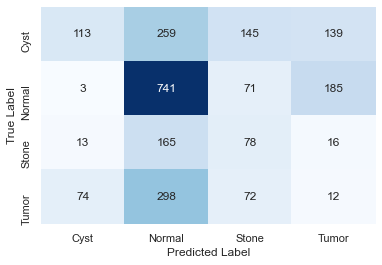

In [215]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [212]:
test_predictions = np.argmax(model1.predict(X_test), axis=-1)
print(test_predictions)

model1accuracy, model1precisions, model1recalls = allClassPrecisionsandRecalls(list(y_test), list(test_predictions))

model1accuracy, model1precisions, model1recalls

75/75 [==============================] - 0s 2ms/step
[1 1 2 ... 1 1 1]


(0.4872331519464211,
 [0.5084745762711864,
  0.5552845528455285,
  0.3069053708439898,
  0.40878378378378377],
 [0.364741641337386,
  0.6823176823176823,
  0.4411764705882353,
  0.26419213973799127])

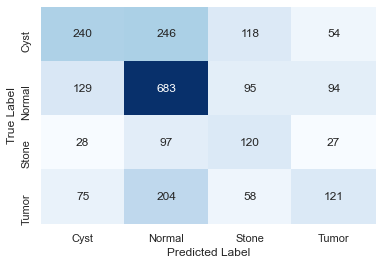

In [213]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [216]:
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 4.009919087092082 minutes


### Model 2 - KNN

In [217]:
model2 = KNeighborsClassifier(n_neighbors=70, p=2, metric='minkowski')
startTime = time.time()
model2.fit(X_train_flat, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model2Time = (endTime - startTime)/60

Training took 0.006364579995473226 minutes


error: 0.6635906040268457
Val prediction accuracy: 0.336


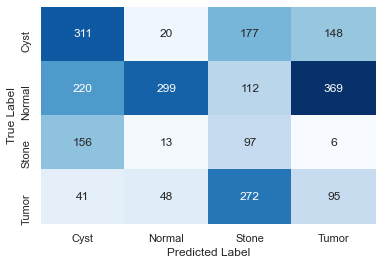

In [218]:
y_pred = model2.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

error: 0.6107157806613646
Test prediction accuracy: 0.389


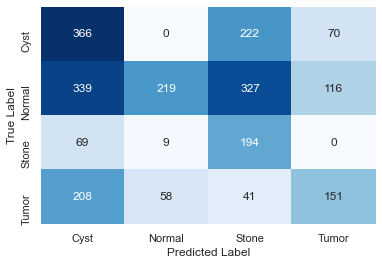

In [219]:
y_pred = model2.predict(X_test_flat)


error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [220]:
model2accuracy, model2precisions, model2recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

model2accuracy, model2precisions, model2recalls

(0.38928421933863544,
 [0.3727087576374745,
  0.7657342657342657,
  0.24744897959183673,
  0.44807121661721067],
 [0.5562310030395137,
  0.21878121878121878,
  0.7132352941176471,
  0.3296943231441048])

### Model 3: Decision Tree

In [221]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
import pydot
from IPython.display import Image, display

In [222]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
startTime = time.time()
dt.fit(X_train_flat, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')
print('Val accuracy:', dt.score(X_val_flat, y_val))
print('Test accuracy:', dt.score(X_test_flat, y_test))

model3Time = (endTime - startTime)/60

Training took 4.4706985036532085 minutes
Val accuracy: 0.4203020134228188
Test accuracy: 0.4123064043532859


In [223]:
y_pred = dt.predict(X_test_flat)

model3accuracy, model3precisions, model3recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

model3accuracy, model3precisions, model3recalls

(0.4123064043532859,
 [0.43337195828505215,
  0.7554806070826307,
  0.09418837675350701,
  0.2672811059907834],
 [0.5683890577507599,
  0.44755244755244755,
  0.17279411764705882,
  0.25327510917030566])

Output: /Users/karachristensen/MidsWork/207/CarriganNeginKaraFinalProject/iris-decisiontree.jpg


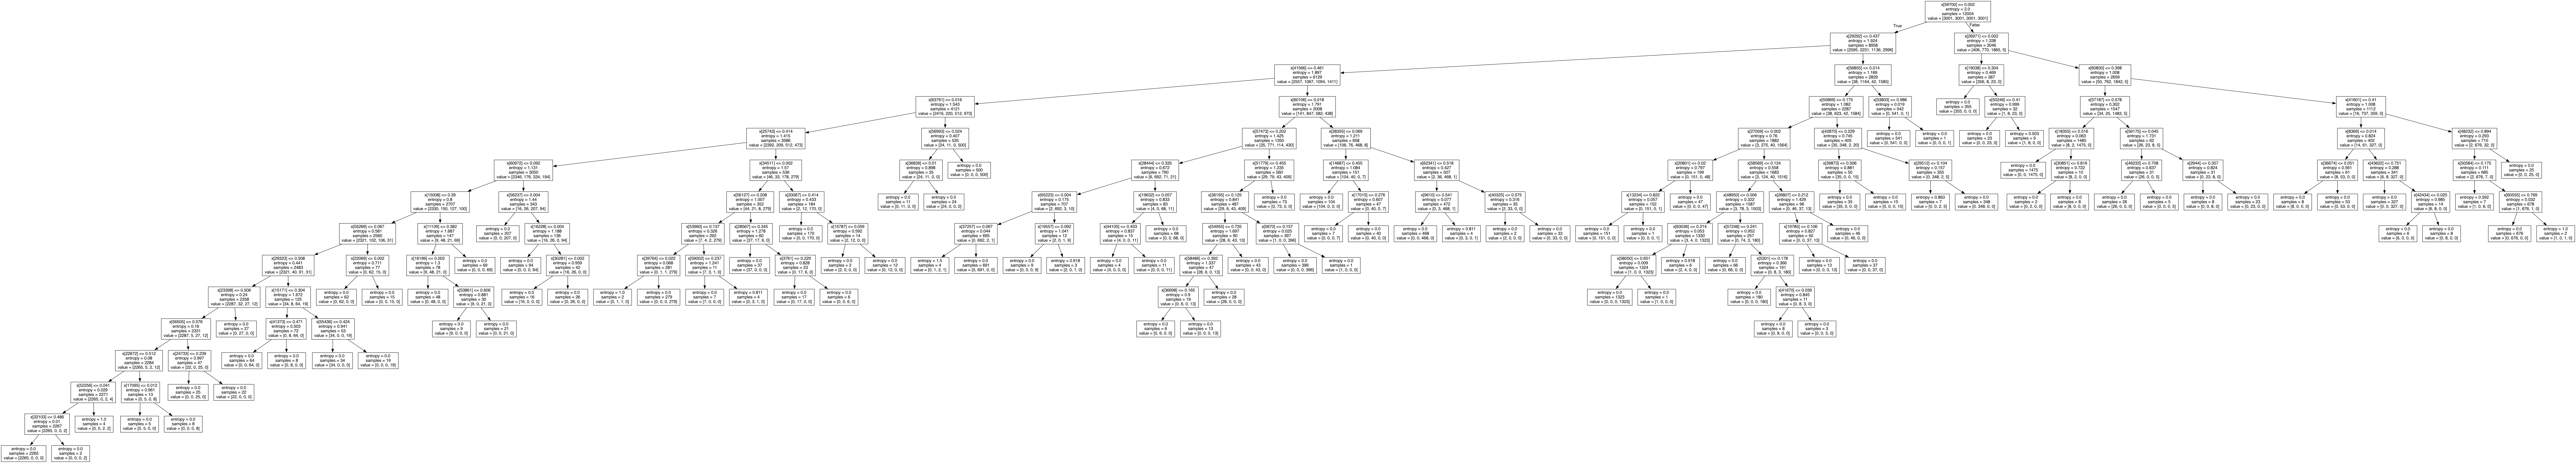

In [224]:
# Export and visualize the trained tree
import os

output_name = 'iris-decisiontree.jpg'
full_path = os.path.join(os.getcwd(), output_name)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]

graph.write_png(output_name)
print('Output:', full_path)
display(Image(filename=full_path))

## Neural Network Machine Learning Models

### Model 4 - Neural Network

##### For this model, we will look at 3 different parameter settings, and choose the one with the highest accuracy

In [225]:
def build_model(n_classes,   #should we change the n_classes to 4? since we only have 4 classes
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    model = tf.keras.models.Sequential()
    # Flatten the input shape
    model.add(data_augmentation)
    model.add(tf.keras.layers.Flatten())
    
    # Add hidden layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(layer_size, activation=activation))
    #Add the last neural network layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))
    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                       recall_c1,
                       precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")
    return model


In [226]:
# Build and compile the model
model4_sgd = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', 
                         optimizer='SGD', learning_rate=0.001)
numEpochs = 15

# Train the model for 5 epochs
startTime = time.time()
history = model4_sgd.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()


model4_sgdTime = endTime - startTime

Epoch 1/15
188/188 [==============================] - 20s 91ms/step - loss: 1.2552 - accuracy: 0.4114 - recall_c1: 0.3031 - precision_c1: 0.5802 - recall_c2: 0.6028 - precision_c2: 0.3604 - recall_c3: 0.3255 - precision_c3: 0.3829 - recall_c4: 0.4177 - precision_c4: 0.4833 - val_loss: 1.2810 - val_accuracy: 0.3922 - val_recall_c1: 0.4151 - val_precision_c1: 0.4878 - val_recall_c2: 0.5829 - val_precision_c2: 0.5229 - val_recall_c3: 0.2594 - val_precision_c3: 0.1906 - val_recall_c4: 0.0322 - val_precision_c4: 0.0463
Epoch 2/15
188/188 [==============================] - 18s 94ms/step - loss: 1.1147 - accuracy: 0.5380 - recall_c1: 0.4920 - precision_c1: 0.6391 - recall_c2: 0.6509 - precision_c2: 0.4723 - recall_c3: 0.4708 - precision_c3: 0.5411 - recall_c4: 0.5432 - precision_c4: 0.6460 - val_loss: 1.2486 - val_accuracy: 0.4388 - val_recall_c1: 0.2749 - val_precision_c1: 0.5282 - val_recall_c2: 0.8147 - val_precision_c2: 0.5046 - val_recall_c3: 0.1440 - val_precision_c3: 0.2227 - val_recal

188/188 [==============================] - 17s 90ms/step - loss: 0.6222 - accuracy: 0.8219 - recall_c1: 0.7759 - precision_c1: 0.8486 - recall_c2: 0.8442 - precision_c2: 0.7967 - recall_c3: 0.8346 - precision_c3: 0.8054 - recall_c4: 0.8284 - precision_c4: 0.8521 - val_loss: 1.3928 - val_accuracy: 0.4174 - val_recall_c1: 0.3587 - val_precision_c1: 0.5110 - val_recall_c2: 0.6482 - val_precision_c2: 0.6301 - val_recall_c3: 0.2980 - val_precision_c3: 0.1867 - val_recall_c4: 0.0450 - val_precision_c4: 0.0522
Epoch 14/15
188/188 [==============================] - 17s 90ms/step - loss: 0.6029 - accuracy: 0.8256 - recall_c1: 0.7930 - precision_c1: 0.8486 - recall_c2: 0.8479 - precision_c2: 0.8002 - recall_c3: 0.8267 - precision_c3: 0.7998 - recall_c4: 0.8375 - precision_c4: 0.8683 - val_loss: 1.3604 - val_accuracy: 0.4161 - val_recall_c1: 0.2895 - val_precision_c1: 0.5581 - val_recall_c2: 0.7036 - val_precision_c2: 0.5836 - val_recall_c3: 0.2170 - val_precision_c3: 0.2382 - val_recall_c4: 0.07

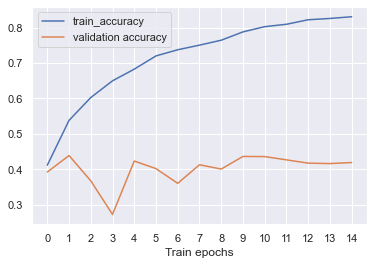

In [227]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [228]:
model4_sgdFinalValAcc = val_accuracy[numEpochs - 1]

In [229]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.255184,0.411446,0.303096,0.580169,0.602753,0.360362,0.325454,0.382925,0.417749,0.483311,1.280967,0.392198,0.415074,0.487834,0.582931,0.522938,0.259355,0.190605,0.032222,0.046289
1,1.114670,0.537987,0.492020,0.639061,0.650880,0.472319,0.470795,0.541081,0.543222,0.645961,1.248582,0.438758,0.274889,0.528163,0.814657,0.504570,0.144012,0.222687,0.026196,0.058772
2,1.029566,0.602383,0.525147,0.665896,0.694358,0.531236,0.577477,0.622915,0.615158,0.705323,1.320538,0.367450,0.247251,0.504394,0.644598,0.492966,0.137861,0.250627,0.062838,0.049959
3,0.962004,0.649617,0.563045,0.699582,0.716073,0.580193,0.623650,0.656721,0.692889,0.736757,1.449996,0.272651,0.160629,0.445517,0.334494,0.486794,0.646758,0.169665,0.057799,0.066897
4,0.904372,0.682522,0.610198,0.734755,0.732676,0.629574,0.676502,0.672119,0.718105,0.772692,1.308813,0.423238,0.323662,0.535405,0.733393,0.517837,0.147938,0.412719,0.040751,0.042317
5,0.847872,0.719843,0.647042,0.761118,0.769830,0.675366,0.726557,0.706094,0.739234,0.787328,1.333910,0.401846,0.176110,0.462030,0.777666,0.503930,0.179726,0.230618,0.017838,0.024980
6,0.807921,0.737254,0.659694,0.770872,0.774051,0.703503,0.754737,0.719490,0.762622,0.796605,1.400884,0.360319,0.171116,0.368963,0.613925,0.583411,0.303308,0.185449,0.100427,0.081471
7,0.772940,0.750250,0.672981,0.800796,0.778068,0.710661,0.765572,0.735118,0.783374,0.795780,1.377396,0.412752,0.350215,0.493789,0.644619,0.616615,0.331034,0.194226,0.034454,0.045574
8,0.738043,0.764162,0.698148,0.792010,0.794331,0.735934,0.783195,0.743175,0.781131,0.814542,1.385088,0.400587,0.288035,0.440520,0.642121,0.613692,0.260753,0.269680,0.114742,0.083300
9,0.701592,0.787654,0.738226,0.830285,0.801623,0.755106,0.798360,0.765577,0.805354,0.822350,1.338950,0.436242,0.270954,0.500543,0.773354,0.579821,0.249808,0.251786,0.036334,0.045552


In [83]:
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')

75/75 [==============================] - 1s 6ms/step


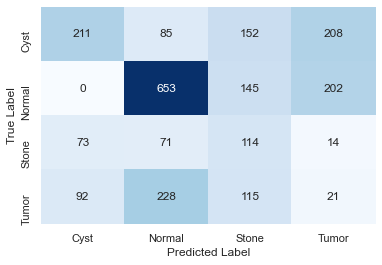

In [230]:
test_predictions = model4_sgd.predict(X_val)
y_pred = np.argmax(test_predictions, axis=-1)



# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

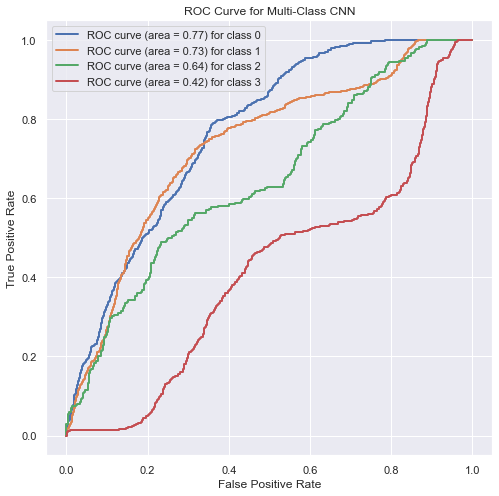

In [231]:
num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class CNN')
plt.legend()
plt.show()

In [232]:
model4_rms = build_model(n_classes=4, hidden_layer_sizes=[256], activation='relu', 
                         optimizer='RMSprop', learning_rate=0.001)

numEpochs = 15

# Train the model for 5 epochs
startTime = time.time()
history = model4_rms.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()
model4_rmsTime = endTime - startTime

Epoch 1/15
188/188 [==============================] - 48s 233ms/step - loss: 5.4003 - accuracy: 0.3431 - recall_c1: 0.3127 - precision_c1: 0.4262 - recall_c2: 0.3809 - precision_c2: 0.2015 - recall_c3: 0.3110 - precision_c3: 0.2493 - recall_c4: 0.3760 - precision_c4: 0.4373 - val_loss: 3.9678 - val_accuracy: 0.1246 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 0.0000e+00 - val_precision_c2: 0.0000e+00 - val_recall_c3: 0.9107 - val_precision_c3: 0.1257 - val_recall_c4: 0.0890 - val_precision_c4: 0.1057
Epoch 2/15
188/188 [==============================] - 43s 231ms/step - loss: 2.1918 - accuracy: 0.4666 - recall_c1: 0.4361 - precision_c1: 0.6223 - recall_c2: 0.4585 - precision_c2: 0.3584 - recall_c3: 0.4295 - precision_c3: 0.4299 - recall_c4: 0.5493 - precision_c4: 0.6664 - val_loss: 2.7828 - val_accuracy: 0.4509 - val_recall_c1: 0.1949 - val_precision_c1: 0.4712 - val_recall_c2: 0.9105 - val_precision_c2: 0.4924 - val_recall_c3: 0.1221 - val_precision_c3: 

188/188 [==============================] - 42s 222ms/step - loss: 0.2090 - accuracy: 0.9225 - recall_c1: 0.9229 - precision_c1: 0.9414 - recall_c2: 0.9187 - precision_c2: 0.9071 - recall_c3: 0.8944 - precision_c3: 0.9121 - recall_c4: 0.9531 - precision_c4: 0.9510 - val_loss: 3.3063 - val_accuracy: 0.3888 - val_recall_c1: 0.5343 - val_precision_c1: 0.4641 - val_recall_c2: 0.4131 - val_precision_c2: 0.6068 - val_recall_c3: 0.4371 - val_precision_c3: 0.2041 - val_recall_c4: 0.0977 - val_precision_c4: 0.1132
Epoch 14/15
188/188 [==============================] - 43s 227ms/step - loss: 0.1944 - accuracy: 0.9306 - recall_c1: 0.9352 - precision_c1: 0.9514 - recall_c2: 0.9237 - precision_c2: 0.9117 - recall_c3: 0.8994 - precision_c3: 0.9181 - recall_c4: 0.9618 - precision_c4: 0.9602 - val_loss: 2.9749 - val_accuracy: 0.4581 - val_recall_c1: 0.4203 - val_precision_c1: 0.6279 - val_recall_c2: 0.6358 - val_precision_c2: 0.6125 - val_recall_c3: 0.1449 - val_precision_c3: 0.1726 - val_recall_c4: 0.

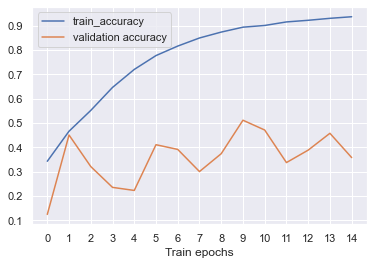

In [233]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [234]:
model4_rmsFinalValAcc = val_accuracy[numEpochs - 1]

In [235]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,5.400290,0.343052,0.312680,0.426167,0.380906,0.201516,0.311031,0.249301,0.375968,0.437336,3.967798,0.124581,0.000000,0.000000,0.000000,0.000000,0.910723,0.125733,0.088964,0.105749
1,2.191849,0.466594,0.436060,0.622294,0.458472,0.358359,0.429525,0.429914,0.549274,0.666391,2.782777,0.450923,0.194900,0.471237,0.910522,0.492352,0.122144,0.140622,0.000000,0.000000
2,1.574152,0.552066,0.507011,0.717525,0.550754,0.523010,0.528712,0.574860,0.632486,0.739389,2.380043,0.321309,0.002770,0.052632,0.684441,0.436206,0.100933,0.195426,0.109492,0.073812
3,1.065808,0.646535,0.614871,0.790489,0.643929,0.653024,0.614796,0.692499,0.708041,0.774047,2.775305,0.235738,0.282554,0.502798,0.195777,0.499686,0.612252,0.132684,0.011302,0.016990
4,0.827038,0.720510,0.694606,0.821836,0.719580,0.743518,0.704268,0.742905,0.773193,0.817745,3.581354,0.223154,0.370678,0.502005,0.046607,0.294674,0.105893,0.205451,0.466643,0.137334
5,0.639881,0.777491,0.762005,0.857030,0.777430,0.784285,0.749061,0.781080,0.829852,0.845818,2.439461,0.411074,0.322492,0.854962,0.676656,0.525153,0.234488,0.114069,0.046238,0.075158
6,0.513806,0.816561,0.806548,0.876382,0.817145,0.801684,0.790223,0.817037,0.853962,0.878846,2.326692,0.391779,0.512224,0.477138,0.420056,0.581381,0.222029,0.288777,0.218651,0.131830
7,0.415323,0.849800,0.851156,0.901925,0.838474,0.836663,0.818873,0.838340,0.890708,0.900970,2.983231,0.300755,0.561582,0.439448,0.169828,0.524535,0.601570,0.168274,0.028468,0.052183
8,0.357144,0.874042,0.874962,0.916640,0.865635,0.859991,0.848812,0.855753,0.906092,0.914797,2.480672,0.374161,0.445170,0.538121,0.401250,0.541878,0.340319,0.272949,0.228571,0.136481
9,0.289481,0.894202,0.893822,0.929002,0.879791,0.878352,0.874131,0.877129,0.928864,0.925901,2.231794,0.511745,0.480955,0.666377,0.714043,0.651735,0.390090,0.319429,0.173149,0.163251


In [86]:
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [87]:
test_predictions = model4_rms.predict(X_val)
y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

In [236]:
model4_adam = build_model(n_classes=4, hidden_layer_sizes=[256], activation='relu', 
                          optimizer='Adam', learning_rate=0.0001)

numEpochs = 15

# Train the model for 5 epochs
startTime = time.time()
history = model4_adam.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()

model4_adamTime = endTime - startTime


Epoch 1/15
188/188 [==============================] - 29s 140ms/step - loss: 1.2030 - accuracy: 0.4776 - recall_c1: 0.3987 - precision_c1: 0.6155 - recall_c2: 0.6301 - precision_c2: 0.4325 - recall_c3: 0.4437 - precision_c3: 0.4779 - recall_c4: 0.4434 - precision_c4: 0.5460 - val_loss: 1.3197 - val_accuracy: 0.4048 - val_recall_c1: 0.2273 - val_precision_c1: 0.3663 - val_recall_c2: 0.7518 - val_precision_c2: 0.5009 - val_recall_c3: 0.0844 - val_precision_c3: 0.2741 - val_recall_c4: 0.0941 - val_precision_c4: 0.1090
Epoch 2/15
188/188 [==============================] - 26s 137ms/step - loss: 0.8132 - accuracy: 0.7267 - recall_c1: 0.6740 - precision_c1: 0.7954 - recall_c2: 0.7893 - precision_c2: 0.6833 - recall_c3: 0.6963 - precision_c3: 0.7014 - recall_c4: 0.7468 - precision_c4: 0.7829 - val_loss: 1.4645 - val_accuracy: 0.4128 - val_recall_c1: 0.3606 - val_precision_c1: 0.4186 - val_recall_c2: 0.6000 - val_precision_c2: 0.6465 - val_recall_c3: 0.2324 - val_precision_c3: 0.2244 - val_rec

188/188 [==============================] - 26s 137ms/step - loss: 0.1244 - accuracy: 0.9771 - recall_c1: 0.9767 - precision_c1: 0.9823 - recall_c2: 0.9807 - precision_c2: 0.9747 - recall_c3: 0.9640 - precision_c3: 0.9690 - recall_c4: 0.9870 - precision_c4: 0.9820 - val_loss: 2.0040 - val_accuracy: 0.4325 - val_recall_c1: 0.3086 - val_precision_c1: 0.5449 - val_recall_c2: 0.5864 - val_precision_c2: 0.6058 - val_recall_c3: 0.4516 - val_precision_c3: 0.2291 - val_recall_c4: 0.2556 - val_precision_c4: 0.2302
Epoch 14/15
188/188 [==============================] - 27s 143ms/step - loss: 0.1136 - accuracy: 0.9788 - recall_c1: 0.9797 - precision_c1: 0.9837 - recall_c2: 0.9767 - precision_c2: 0.9786 - recall_c3: 0.9709 - precision_c3: 0.9693 - recall_c4: 0.9883 - precision_c4: 0.9827 - val_loss: 2.1218 - val_accuracy: 0.4169 - val_recall_c1: 0.2326 - val_precision_c1: 0.6633 - val_recall_c2: 0.5887 - val_precision_c2: 0.6175 - val_recall_c3: 0.4560 - val_precision_c3: 0.2111 - val_recall_c4: 0.

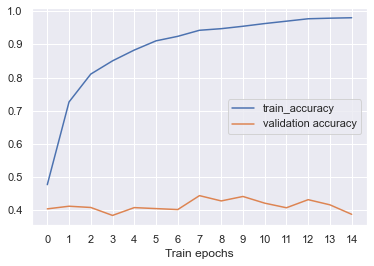

In [237]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [238]:
model4_adamFinalValAcc = val_accuracy[numEpochs - 1]

In [239]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.202951,0.477591,0.398704,0.615518,0.630099,0.432494,0.443684,0.477879,0.443366,0.546014,1.319658,0.404782,0.227318,0.366251,0.751770,0.500898,0.084444,0.274123,0.094130,0.109041
1,0.813181,0.726674,0.674022,0.795364,0.789341,0.683310,0.696333,0.701391,0.746804,0.782861,1.464466,0.412752,0.360594,0.418629,0.600022,0.646541,0.232389,0.224387,0.167905,0.129944
2,0.607521,0.810563,0.763572,0.863631,0.864927,0.794059,0.792864,0.770305,0.819685,0.848993,1.548855,0.408976,0.254442,0.593008,0.662412,0.542735,0.281659,0.199062,0.135412,0.127523
3,0.487746,0.850383,0.823824,0.880316,0.887960,0.834344,0.823904,0.813241,0.861448,0.890750,1.746406,0.385067,0.203594,0.741980,0.526732,0.575771,0.488190,0.190633,0.262539,0.203930
4,0.401703,0.882872,0.858550,0.903921,0.914730,0.875278,0.860936,0.838624,0.903373,0.928628,1.626292,0.408557,0.287497,0.571416,0.585321,0.558254,0.328914,0.215346,0.236320,0.188254
5,0.329823,0.910613,0.895293,0.935198,0.926631,0.907681,0.893476,0.874807,0.928157,0.937834,1.710155,0.405621,0.314998,0.518127,0.561016,0.547750,0.276949,0.191076,0.265146,0.214747
6,0.285047,0.924192,0.918205,0.945094,0.940674,0.917406,0.899010,0.895933,0.941308,0.946587,1.815162,0.402685,0.344415,0.493735,0.530220,0.613712,0.318941,0.176744,0.242067,0.198054
7,0.243105,0.942436,0.937217,0.953465,0.946686,0.938153,0.925044,0.922513,0.959373,0.961479,1.746067,0.444631,0.354364,0.546232,0.623861,0.595063,0.300478,0.211895,0.259599,0.227950
8,0.212064,0.947268,0.941869,0.961636,0.953866,0.938157,0.930592,0.926534,0.961759,0.963329,1.844484,0.428691,0.367341,0.516975,0.573018,0.604000,0.322701,0.208124,0.258194,0.217206
9,0.191510,0.954515,0.952105,0.965320,0.958926,0.949851,0.938159,0.934706,0.968905,0.970678,1.783490,0.442114,0.255261,0.621680,0.648478,0.621400,0.419289,0.224425,0.254392,0.213492


In [81]:
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 4.9663851141929625 minutes


In [ ]:

test_predictions = model4_adam.predict(X_val)
y_pred = np.argmax(test_predictions, axis=-1)

# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

The best optimizer was SGD
Training took 4.258585015932719 minutes
75/75 [==============================] - 1s 16ms/step


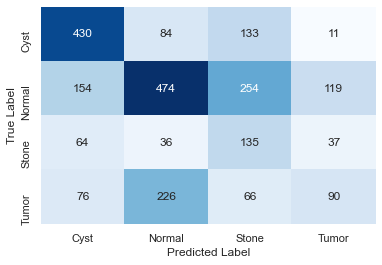

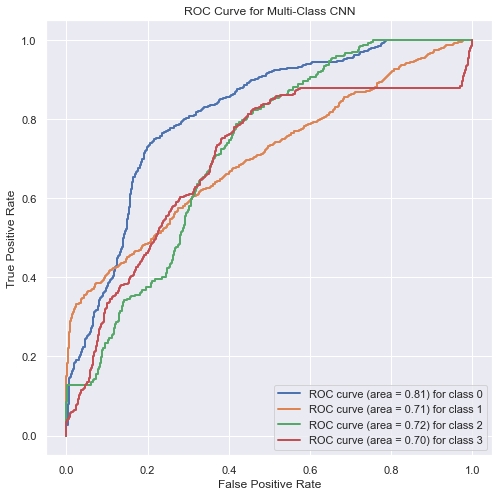

(0.4725826705734617,
 [0.5939226519337016,
  0.5780487804878048,
  0.22959183673469388,
  0.35019455252918286],
 [0.6534954407294833,
  0.47352647352647353,
  0.4963235294117647,
  0.1965065502183406])

In [240]:
# Find which model is best, and run relevant methods

model4_sgdTime, model4_rmsTime, model4_adamTime
model4_sgdFinalValAcc, model4_rmsFinalValAcc, model4_adamFinalValAcc

if model4_sgdFinalValAcc >= model4_rmsFinalValAcc and model4_sgdFinalValAcc >= model4_adamFinalValAcc:
    print('The best optimizer was SGD')
    print('Training took ' + str(model4_sgdTime/60) + ' minutes')
    model4Time = model4_sgdTime/60
    test_predictions = model4_sgd.predict(X_test)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model4accuracy, model4precisions, model4recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()


elif model4_rmsFinalValAcc >= model4_sgdFinalValAcc and model4_rmsFinalValAcc >= model4_adamFinalValAcc:
    print('The best optimizer was RMS')
    print('Training took ' + str(model4_rmsTime/60) + ' minutes')
    model4Time = model4_rmsTime/60
    test_predictions = model4_rms.predict(X_test)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model4accuracy, model4precisions, model4recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))


    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

   # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
else:
    print('The best optimizer was Adam')
    print('Training took ' + str(model4_adamTime/60) + ' minutes')
    model4Time = model4_adamTime/60

    test_predictions = model4adam.predict(X_test)
    y_pred = np.argmax(test_predictions, axis=-1)


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model4accuracy, model4precisions, model4recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))
    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

   # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()

model4accuracy, model4precisions, model4recalls

### Models 5-6 - CNN

In [241]:
def build_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):

    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()
    model.add(data_augmentation)

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [242]:
input_shape = (32, 32, 3)  # Change this according to your image dimensions

In [243]:
#new_shape = (32, 32, 3)
X_train_reshaped = np.reshape(X_train_flat, (-1, 256, 256, 1))
X_val_reshaped = np.reshape(X_val_flat, (-1, 256, 256, 1))
X_test_reshaped = np.reshape(X_test_flat, (-1, 256, 256, 1))
# Normalize pixel values to range [0, 1]
# X_train_reshaped = X_train_reshaped / 255.0
# X_val_reshaped = X_val_reshaped / 255.0
# X_test_reshaped = X_test_reshaped / 255.0


X_train_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_train_reshaped])
X_val_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_val_reshaped])
X_test_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_test_reshaped])


In [244]:
X_train_rgb = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val_resized[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test_resized[..., np.newaxis], 3, axis=-1)

# Reshape to remove the extra dimension
X_train_rgb = np.squeeze(X_train_rgb, axis=3)
X_val_rgb = np.squeeze(X_val_rgb, axis=3)
X_test_rgb = np.squeeze(X_test_rgb, axis=3)


In [284]:
# Train the CNN model for 5 epochs
cnn_model_sgd = build_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.001)
numEpochs = 25
startTime = time.time()
history_cnn = cnn_model_sgd.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
model5_sgdTime = (endTime - startTime)

Epoch 1/25
188/188 [==============================] - 11s 44ms/step - loss: 1.3861 - accuracy: 0.2812 - recall_c1: 0.5799 - precision_c1: 0.3164 - recall_c2: 2.9551e-04 - precision_c2: 0.0053 - recall_c3: 0.0000e+00 - precision_c3: 0.0000e+00 - recall_c4: 0.5344 - precision_c4: 0.2545 - val_loss: 1.3818 - val_accuracy: 0.3117 - val_recall_c1: 0.5757 - val_precision_c1: 0.5160 - val_recall_c2: 0.0000e+00 - val_precision_c2: 0.0000e+00 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 0.7983 - val_precision_c4: 0.2265
Epoch 2/25
188/188 [==============================] - 8s 43ms/step - loss: 1.3833 - accuracy: 0.3108 - recall_c1: 0.3765 - precision_c1: 0.4878 - recall_c2: 0.0548 - precision_c2: 0.2057 - recall_c3: 2.9551e-04 - precision_c3: 0.0053 - recall_c4: 0.8182 - precision_c4: 0.2682 - val_loss: 1.3759 - val_accuracy: 0.3314 - val_recall_c1: 0.4699 - val_precision_c1: 0.7372 - val_recall_c2: 0.1622 - val_precision_c2: 0.4380 - val_recall_c3: 0.0000e+00 - v

188/188 [==============================] - 7s 40ms/step - loss: 1.3466 - accuracy: 0.3867 - recall_c1: 0.4332 - precision_c1: 0.6167 - recall_c2: 0.9064 - precision_c2: 0.3604 - recall_c3: 0.0192 - precision_c3: 0.1821 - recall_c4: 0.1890 - precision_c4: 0.2665 - val_loss: 1.3173 - val_accuracy: 0.5889 - val_recall_c1: 0.6384 - val_precision_c1: 0.8047 - val_recall_c2: 0.8632 - val_precision_c2: 0.6601 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 0.2461 - val_precision_c4: 0.2089
Epoch 14/25
188/188 [==============================] - 7s 39ms/step - loss: 1.3402 - accuracy: 0.3996 - recall_c1: 0.4786 - precision_c1: 0.6058 - recall_c2: 0.8914 - precision_c2: 0.3711 - recall_c3: 0.0264 - precision_c3: 0.2484 - recall_c4: 0.1994 - precision_c4: 0.2719 - val_loss: 1.3083 - val_accuracy: 0.5889 - val_recall_c1: 0.6445 - val_precision_c1: 0.7633 - val_recall_c2: 0.8572 - val_precision_c2: 0.6738 - val_recall_c3: 0.0095 - val_precision_c3: 0.0789 - val_recall_c4

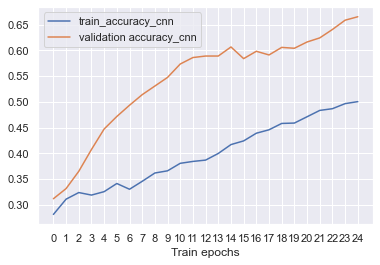

In [285]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [286]:
model5_sgdFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [248]:
history = pd.DataFrame(history_cnn.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.383963,0.259080,0.000000,0.000000,0.974190,0.257713,0.000000,0.000000,0.061541,0.275469,1.371199,0.404362,0.000000,0.000000,0.925748,0.437134,0.000000,0.000000,0.089721,0.140394
1,1.379752,0.267744,0.000000,0.000000,0.966072,0.267949,0.000000,0.000000,0.105571,0.273635,1.367105,0.405621,0.000000,0.000000,0.947025,0.444038,0.000000,0.000000,0.047418,0.081423
2,1.375457,0.269993,0.000000,0.000000,0.975890,0.268312,0.000266,0.005319,0.103605,0.283906,1.362256,0.400168,0.000000,0.000000,0.930535,0.449883,0.000000,0.000000,0.056679,0.075067
3,1.371362,0.277741,0.000000,0.000000,0.974145,0.276377,0.001466,0.021277,0.136591,0.293374,1.357560,0.399329,0.000000,0.000000,0.923201,0.455540,0.005263,0.026316,0.066175,0.083348
4,1.367180,0.281739,0.000000,0.000000,0.963426,0.287737,0.014962,0.114184,0.148912,0.274666,1.350905,0.409396,0.000000,0.000000,0.941713,0.466927,0.033104,0.179825,0.054858,0.073519
5,1.361959,0.288904,0.013400,0.139184,0.968241,0.293674,0.035732,0.220320,0.137387,0.257422,1.342857,0.423238,0.020582,0.342105,0.974978,0.468197,0.045165,0.142105,0.017323,0.027694
6,1.356804,0.295402,0.056882,0.405446,0.978620,0.293604,0.058861,0.313665,0.085590,0.236431,1.336337,0.438758,0.089146,0.660526,0.969733,0.492139,0.027360,0.060088,0.024436,0.039851
7,1.350783,0.324642,0.155747,0.621538,0.977888,0.305304,0.070696,0.334135,0.095728,0.272829,1.327937,0.464765,0.189193,0.798496,0.971353,0.512638,0.000000,0.000000,0.030116,0.048716
8,1.344289,0.344219,0.234625,0.610977,0.962169,0.318418,0.064152,0.315521,0.114189,0.298848,1.317227,0.499581,0.299163,0.862810,0.984756,0.514590,0.000000,0.000000,0.024055,0.044256
9,1.336635,0.353465,0.293283,0.598516,0.962534,0.322898,0.051698,0.248771,0.112394,0.332499,1.306588,0.524748,0.384427,0.873216,0.985467,0.530245,0.000000,0.000000,0.026989,0.052834


In [ ]:
# test_predictions = cnn_model_sgd.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [287]:
cnn_model_adam = build_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.0001)
numEpochs = 15
startTime = time.time()
history_cnn = cnn_model_adam.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model5_adamTime = (endTime - startTime)

Epoch 1/15
188/188 [==============================] - 14s 46ms/step - loss: 1.2380 - accuracy: 0.4414 - recall_c1: 0.6390 - precision_c1: 0.4725 - recall_c2: 0.7354 - precision_c2: 0.4314 - recall_c3: 0.1453 - precision_c3: 0.2270 - recall_c4: 0.2460 - precision_c4: 0.3257 - val_loss: 1.1454 - val_accuracy: 0.4656 - val_recall_c1: 1.0000 - val_precision_c1: 0.4934 - val_recall_c2: 0.3488 - val_precision_c2: 1.0000 - val_recall_c3: 0.0566 - val_precision_c3: 0.0784 - val_recall_c4: 0.2057 - val_precision_c4: 0.1840
Epoch 2/15
188/188 [==============================] - 8s 44ms/step - loss: 1.0573 - accuracy: 0.5397 - recall_c1: 0.7517 - precision_c1: 0.5907 - recall_c2: 0.7319 - precision_c2: 0.5501 - recall_c3: 0.2798 - precision_c3: 0.4180 - recall_c4: 0.4013 - precision_c4: 0.6026 - val_loss: 1.3126 - val_accuracy: 0.4006 - val_recall_c1: 0.9933 - val_precision_c1: 0.4633 - val_recall_c2: 0.2469 - val_precision_c2: 0.9737 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - va

188/188 [==============================] - 8s 41ms/step - loss: 0.3489 - accuracy: 0.8840 - recall_c1: 0.9290 - precision_c1: 0.8904 - recall_c2: 0.8649 - precision_c2: 0.8849 - recall_c3: 0.8401 - precision_c3: 0.8481 - recall_c4: 0.8988 - precision_c4: 0.9247 - val_loss: 1.5948 - val_accuracy: 0.5575 - val_recall_c1: 0.6893 - val_precision_c1: 0.6170 - val_recall_c2: 0.6250 - val_precision_c2: 0.8391 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 0.5739 - val_precision_c4: 0.2927
Epoch 14/15
188/188 [==============================] - 8s 42ms/step - loss: 0.3257 - accuracy: 0.8894 - recall_c1: 0.9292 - precision_c1: 0.8935 - recall_c2: 0.8771 - precision_c2: 0.8903 - recall_c3: 0.8435 - precision_c3: 0.8581 - recall_c4: 0.9124 - precision_c4: 0.9294 - val_loss: 1.6200 - val_accuracy: 0.5352 - val_recall_c1: 0.6898 - val_precision_c1: 0.5840 - val_recall_c2: 0.5571 - val_precision_c2: 0.8709 - val_recall_c3: 0.1026 - val_precision_c3: 0.2504 - val_recall_c4

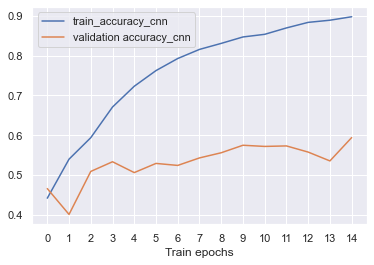

In [288]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [289]:
model5_adamFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [252]:
history = pd.DataFrame(history_cnn.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.254277,0.445185,0.691805,0.504100,0.722414,0.436647,0.139187,0.293808,0.230418,0.338769,1.210096,0.385906,1.000000,0.450519,0.242851,1.000000,0.126026,0.081671,0.000000,0.000000
1,1.037056,0.550983,0.758404,0.586397,0.731372,0.543816,0.303403,0.457220,0.413047,0.657499,1.271652,0.402685,0.998684,0.460244,0.250780,1.000000,0.221998,0.158407,0.000000,0.000000
2,0.887311,0.619460,0.762844,0.645207,0.720008,0.629166,0.432437,0.508765,0.561568,0.745085,1.176182,0.503356,0.827832,0.581102,0.391172,1.000000,0.334220,0.287817,0.386674,0.241899
3,0.768309,0.681523,0.769900,0.690890,0.737367,0.694335,0.534949,0.587042,0.688117,0.795568,1.138651,0.530621,0.836125,0.652511,0.488717,0.979344,0.415958,0.192382,0.261045,0.255869
4,0.680733,0.736588,0.810559,0.747305,0.749901,0.755277,0.639683,0.662043,0.741559,0.833267,1.230881,0.532718,0.780376,0.524396,0.529093,0.993293,0.262509,0.270457,0.358342,0.261557
5,0.601337,0.774492,0.849530,0.777191,0.760848,0.786662,0.693738,0.713381,0.790781,0.859196,1.213342,0.538591,0.842481,0.526329,0.585315,0.938951,0.238982,0.211456,0.179436,0.200487
6,0.552136,0.795318,0.858942,0.799008,0.798839,0.803328,0.722455,0.743055,0.808313,0.865438,1.292310,0.557047,0.647735,0.637393,0.537520,0.894212,0.242438,0.489568,0.655873,0.306932
7,0.507626,0.815145,0.867696,0.821001,0.804098,0.825863,0.760535,0.766502,0.834219,0.876449,1.176154,0.581376,0.788442,0.585375,0.630089,0.874588,0.107408,0.326002,0.472328,0.325438
8,0.460855,0.840387,0.886699,0.836088,0.833093,0.843409,0.797646,0.808357,0.845663,0.889952,1.255589,0.565017,0.644604,0.618669,0.605354,0.852785,0.140513,0.456015,0.627622,0.314651
9,0.429215,0.848051,0.885172,0.845576,0.834414,0.852861,0.796454,0.813325,0.868148,0.895845,1.127499,0.575923,0.544908,0.670513,0.691717,0.783983,0.320145,0.651023,0.520171,0.281707


In [ ]:
# test_predictions = cnn_model_adam.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

In [290]:
cnn_model_rms = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.001)
numEpochs = 10
startTime = time.time()
history_cnn = cnn_model_rms.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model5_rmsTime = (endTime - startTime)

Epoch 1/10
188/188 [==============================] - 11s 43ms/step - loss: 1.1091 - accuracy: 0.4925 - recall_c1: 0.6758 - precision_c1: 0.5665 - recall_c2: 0.6566 - precision_c2: 0.4886 - recall_c3: 0.2690 - precision_c3: 0.3965 - recall_c4: 0.3684 - precision_c4: 0.5501 - val_loss: 1.9145 - val_accuracy: 0.3540 - val_recall_c1: 0.7308 - val_precision_c1: 0.3191 - val_recall_c2: 0.3745 - val_precision_c2: 1.0000 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 0.0044 - val_precision_c4: 0.0041
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.7082 - accuracy: 0.6978 - recall_c1: 0.7879 - precision_c1: 0.7526 - recall_c2: 0.6982 - precision_c2: 0.7157 - recall_c3: 0.5926 - precision_c3: 0.6769 - recall_c4: 0.7172 - precision_c4: 0.7989 - val_loss: 1.4744 - val_accuracy: 0.5348 - val_recall_c1: 0.7410 - val_precision_c1: 0.5281 - val_recall_c2: 0.6675 - val_precision_c2: 0.8008 - val_recall_c3: 0.2173 - val_precision_c3: 0.3441 - va

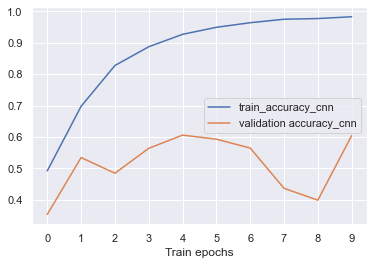

In [291]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [292]:
model5_rmsFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [ ]:
# test_predictions = cnn_model_rms.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)



# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

The best optimizer was SGD
Training took 3.3038349509239198 minutes
75/75 [==============================] - 0s 2ms/step


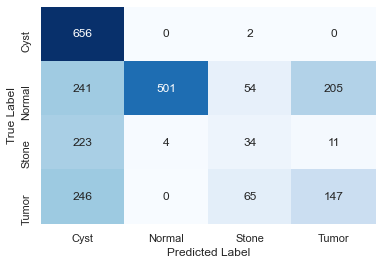

<Figure size 432x288 with 0 Axes>

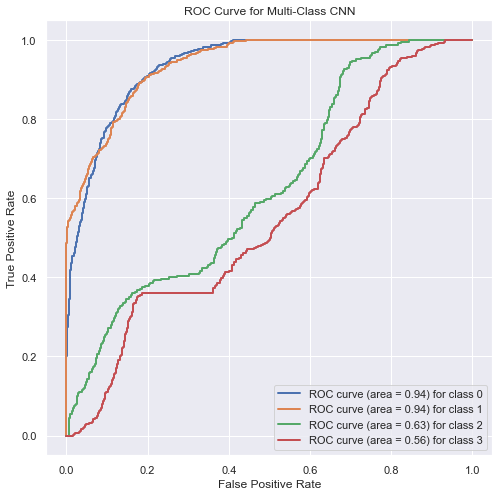

(0.5600669736291335,
 [0.4802342606149341,
  0.9920792079207921,
  0.21935483870967742,
  0.4049586776859504],
 [0.9969604863221885, 0.5004995004995005, 0.125, 0.32096069868995636])

<Figure size 432x288 with 0 Axes>

In [293]:
if model5_sgdFinalValAcc >= model5_rmsFinalValAcc and model5_sgdFinalValAcc >= model5_adamFinalValAcc:
    print('The best optimizer was SGD')
    print('Training took ' + str(model5_sgdTime/60) + ' minutes')
    test_predictions = cnn_model_sgd.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)
    model5Time = model5_sgdTime/60


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model5accuracy, model5precisions, model5recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))
    
    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    plt.savefig('Model5ConMatrix.png')
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
    plt.savefig('Model5ROCCurve.png')


elif model5_rmsFinalValAcc >= model5_sgdFinalValAcc and model5_rmsFinalValAcc >= model5_adamFinalValAcc:
    print('The best optimizer was RMS')
    print('Training took ' + str(model5_rmsTime/60) + ' minutes')
    test_predictions = cnn_model_rms.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)
    model5Time = model5_rmsTime/60


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model5accuracy, model5precisions, model5recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    plt.savefig('Model5ConMatrix.png')
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
    plt.savefig('Model5ROCCurve.png')
else:
    print('The best optimizer was Adam')
    print('Training took ' + str(model5_adamTime/60) + ' minutes')
    test_predictions = cnn_model_adam.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)
    model5Time = model5_adamTime/60


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model5accuracy, model5precisions, model5recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))
    
    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    plt.savefig('Model5ConMatrix.png')
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
    plt.savefig('Model5ROCCurve.png')

model5accuracy, model5precisions, model5recalls

In [294]:
#building a new CNN model increasing the number of filters

def build_new_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):
    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()
    model.add(data_augmentation)

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Adding drop out layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [295]:
cnn_model_rms = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.001)
numEpochs = 10
startTime = time.time()
history_cnn = cnn_model_rms.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
model6_rmsTime = (endTime - startTime)

Epoch 1/10
188/188 [==============================] - 10s 41ms/step - loss: 1.0956 - accuracy: 0.5067 - recall_c1: 0.6708 - precision_c1: 0.5698 - recall_c2: 0.6498 - precision_c2: 0.4948 - recall_c3: 0.2679 - precision_c3: 0.4000 - recall_c4: 0.4378 - precision_c4: 0.5970 - val_loss: 1.4055 - val_accuracy: 0.4996 - val_recall_c1: 0.5991 - val_precision_c1: 0.4360 - val_recall_c2: 0.6707 - val_precision_c2: 0.9742 - val_recall_c3: 0.3410 - val_precision_c3: 0.3041 - val_recall_c4: 0.0868 - val_precision_c4: 0.0779
Epoch 2/10
188/188 [==============================] - 7s 39ms/step - loss: 0.6932 - accuracy: 0.7153 - recall_c1: 0.7648 - precision_c1: 0.7640 - recall_c2: 0.7252 - precision_c2: 0.7528 - recall_c3: 0.6309 - precision_c3: 0.6957 - recall_c4: 0.7475 - precision_c4: 0.8075 - val_loss: 1.4800 - val_accuracy: 0.5185 - val_recall_c1: 0.6145 - val_precision_c1: 0.6631 - val_recall_c2: 0.6796 - val_precision_c2: 0.7460 - val_recall_c3: 0.1923 - val_precision_c3: 0.2531 - val_recall

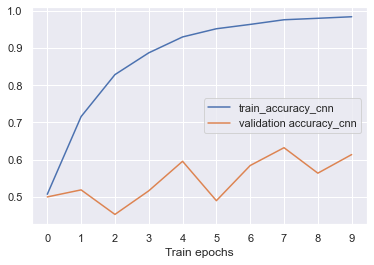

In [296]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [297]:
model6_rmsFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [ ]:
# test_predictions = cnn_model_rms.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

In [298]:
cnn_model_sgd = build_new_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.01)
numEpochs = 20
startTime = time.time()
history_cnn = cnn_model_sgd.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model6_sgdTime = (endTime - startTime)

Epoch 1/20
188/188 [==============================] - 15s 70ms/step - loss: 1.3772 - accuracy: 0.2943 - val_loss: 1.3385 - val_accuracy: 0.4702
Epoch 2/20
188/188 [==============================] - 13s 69ms/step - loss: 1.3401 - accuracy: 0.3710 - val_loss: 1.2392 - val_accuracy: 0.6326
Epoch 3/20
188/188 [==============================] - 13s 71ms/step - loss: 1.2461 - accuracy: 0.4352 - val_loss: 1.0533 - val_accuracy: 0.6732
Epoch 4/20
188/188 [==============================] - 13s 70ms/step - loss: 1.1569 - accuracy: 0.4743 - val_loss: 0.9782 - val_accuracy: 0.6527
Epoch 5/20
188/188 [==============================] - 13s 71ms/step - loss: 1.1200 - accuracy: 0.4913 - val_loss: 0.9250 - val_accuracy: 0.6548
Epoch 6/20
188/188 [==============================] - 13s 71ms/step - loss: 1.0885 - accuracy: 0.5077 - val_loss: 0.9276 - val_accuracy: 0.6275
Epoch 7/20
188/188 [==============================] - 13s 71ms/step - loss: 1.0657 - accuracy: 0.5197 - val_loss: 0.9583 - val_accuracy:

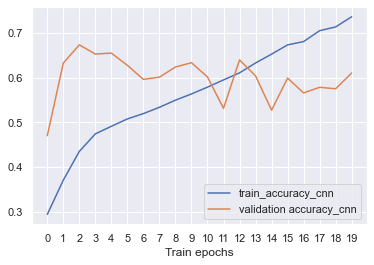

In [299]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [300]:
model6_sgdFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [ ]:
# test_predictions = cnn_model_sgd.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

In [301]:
cnn_model_adam = build_new_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.001)
numEpochs = 15
startTime = time.time()
history_cnn = cnn_model_adam.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
# print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model6_adamTime = (endTime - startTime)

Epoch 1/15
188/188 [==============================] - 16s 73ms/step - loss: 1.1439 - accuracy: 0.4635 - val_loss: 1.5131 - val_accuracy: 0.5067
Epoch 2/15
188/188 [==============================] - 14s 73ms/step - loss: 0.6319 - accuracy: 0.7283 - val_loss: 1.7829 - val_accuracy: 0.5021
Epoch 3/15
188/188 [==============================] - 14s 72ms/step - loss: 0.3073 - accuracy: 0.8823 - val_loss: 2.5333 - val_accuracy: 0.4899
Epoch 4/15
188/188 [==============================] - 14s 73ms/step - loss: 0.1657 - accuracy: 0.9401 - val_loss: 2.2723 - val_accuracy: 0.5562
Epoch 5/15
188/188 [==============================] - 14s 73ms/step - loss: 0.1346 - accuracy: 0.9531 - val_loss: 2.9934 - val_accuracy: 0.5466
Epoch 6/15
188/188 [==============================] - 14s 73ms/step - loss: 0.0907 - accuracy: 0.9678 - val_loss: 3.0597 - val_accuracy: 0.5633
Epoch 7/15
188/188 [==============================] - 14s 73ms/step - loss: 0.0572 - accuracy: 0.9802 - val_loss: 3.6774 - val_accuracy:

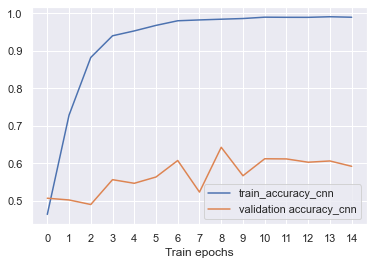

In [303]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [304]:
model6_adamFinalValAcc = val_accuracy_cnn[numEpochs - 1]

In [ ]:
# test_predictions = cnn_model_adam.predict(X_val_rgb)
# y_pred = np.argmax(test_predictions, axis=-1)


# # Create a confusion matrix as a 2D array.
# confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# # Use a heatmap plot to display it.
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
#                  cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()

In [ ]:
# num_classes = np.max(y_val) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_val, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

The best optimizer was RMS
Training took 1.2924467166264852 minutes
75/75 [==============================] - 0s 2ms/step


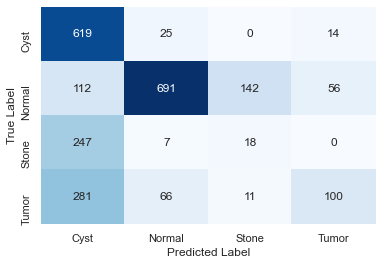

<Figure size 432x288 with 0 Axes>

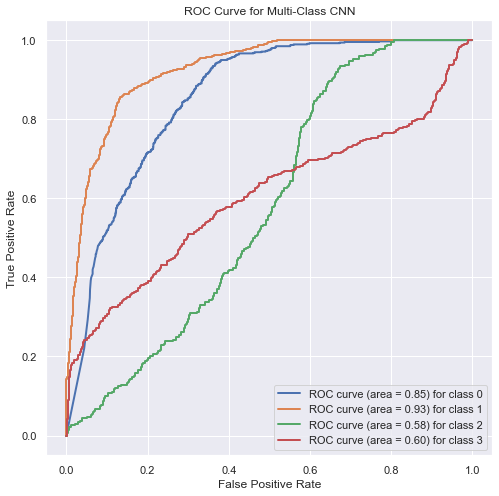

(0.5600669736291335,
 [0.4802342606149341,
  0.9920792079207921,
  0.21935483870967742,
  0.4049586776859504],
 [0.9969604863221885, 0.5004995004995005, 0.125, 0.32096069868995636])

<Figure size 432x288 with 0 Axes>

In [305]:
if model6_sgdFinalValAcc >= model6_rmsFinalValAcc and model6_sgdFinalValAcc >= model6_adamFinalValAcc:
    print('The best optimizer was SGD')
    print('Training took ' + str(model6_sgdTime/60) + ' minutes')
    test_predictions = cnn_model_sgd.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)
    model6Time = model6_sgdTime/60
    


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model6accuracy, model6precisions, model6recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    plt.savefig('Model6ConMatrix.png')
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
    plt.savefig('Model6ROCCurve.png')

elif model6_rmsFinalValAcc >= model6_sgdFinalValAcc and model6_rmsFinalValAcc >= model6_adamFinalValAcc:
    print('The best optimizer was RMS')
    print('Training took ' + str(model6_rmsTime/60) + ' minutes')
    test_predictions = cnn_model_rms.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)
    model6Time = model6_rmsTime/60


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model6accuracy, model6precisions, model6recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    plt.savefig('Model6ConMatrix.png')
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
    plt.savefig('Model6ROCCurve.png')
else:
    print('The best optimizer was Adam')
    print('Training took ' + str(model6_adamTime/60) + ' minutes')
    test_predictions = cnn_model_adam.predict(X_test_rgb)
    y_pred = np.argmax(test_predictions, axis=-1)
    model6Time = model6_adamTime/60


    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
    
    model6accuracy, model6precisions, model6recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                     cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    plt.savefig('Model6ConMatrix.png')
    
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class CNN')
    plt.legend()
    plt.show()
    plt.savefig('Model6ROCCurve.png')

model5accuracy, model5precisions, model5recalls

### Test CNN Model and Create ROC Curve
##### Now in above code block


In [ ]:
# predictions = cnn_model.predict(X_test_rgb)
# class_predictions = np.argmax(predictions, axis=-1)
# print(class_predictions)

In [ ]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize

# num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
# y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot the ROC curve for each class
# plt.figure(figsize=(8, 8))
# for i in range(4):
#     plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class CNN')
# plt.legend()
# plt.show()

## Ensemble Machine Learning Models

### Model 7 - Random Forest

In [268]:
if len(X_train.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_train.shape[0]
    X_train_flatish = X_train.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact


In [269]:
if len(X_test.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_test.shape[0]
    X_test_flatish = X_test.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact

In [281]:
rf_classifier = RandomForestClassifier(n_estimators=4, random_state=42)

# Training the Random Forest classifier
startTime = time.time()
rf_classifier.fit(X_train_flatish, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model7Time = (endTime - startTime)/60

# Making predictions on the test set
predictions = rf_classifier.predict(X_test_flatish)

# Evaluating the model
accuracy = rf_classifier.score(X_test_flatish, y_test)
print(f"Random Forest Classifier Accuracy: {accuracy}")

Training took 0.18618568579355876 minutes
Random Forest Classifier Accuracy: 0.5889493511929678


In [271]:
model7accuracy, model7precisions, model7recalls = allClassPrecisionsandRecalls(list(y_test), list(predictions))
model7accuracy, model7precisions, model7recalls

(0.5889493511929678,
 [0.5292479108635098,
  0.8102016607354685,
  0.21348314606741572,
  0.39862542955326463],
 [0.8662613981762918,
  0.6823176823176823,
  0.13970588235294118,
  0.25327510917030566])

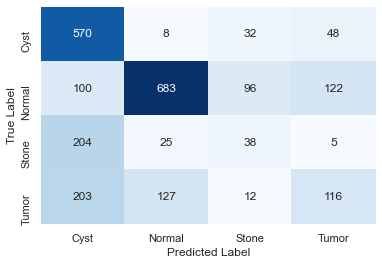

In [272]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Model 8 - XGBoost

In [273]:
model8 = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)
startTime = time.time()
model8.fit(X_train_flat, y_train)
endTime = time.time()
model8Time = (endTime - startTime)/60
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 9.602502330144246 minutes


error: 0.42953020134228187
Val prediction accuracy: 0.570


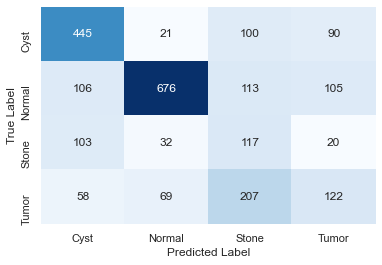

In [274]:
y_pred = model8.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

error: 0.45542067810799497
Test prediction accuracy: 0.545


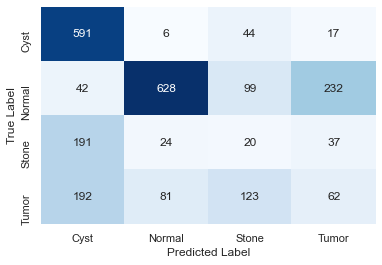

In [275]:
y_pred = model8.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [276]:
model8accuracy, model8precisions, model8recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))
model8accuracy, model8precisions, model8recalls

(0.544579321892005,
 [0.5816929133858267,
  0.8497970230040596,
  0.06993006993006994,
  0.1781609195402299],
 [0.898176291793313,
  0.6273726273726273,
  0.07352941176470588,
  0.13537117903930132])

### Model 9 - Transfer Learning

In [199]:
# Should have shape (12004, 256, 256, 1) at start of cell

print(X_train.shape, X_val.shape, X_test.shape)
X_train_3_channel = X_train.repeat(3, axis=-1)
X_val_3_channel = X_val.repeat(3, axis = -1)
X_test_3_channel = X_test.repeat(3, axis = -1)

print(X_train_3_channel.shape, X_val_3_channel.shape, X_test_3_channel.shape)

(12004, 256, 256, 1) (2384, 256, 256, 1) (2389, 256, 256, 1)
(12004, 256, 256, 3) (2384, 256, 256, 3) (2389, 256, 256, 3)


In [201]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

In [202]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
               keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)


inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model9 = keras.Model(inputs, outputs)

model9.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0   

In [203]:
model9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
startTime = time.time()
history = model9.fit(X_train_3_channel, 
                     y_train, 
                     epochs=10, 
                     batch_size=128, 
                     validation_data = (X_val_3_channel, y_val))
endTime = time.time()

model9Time = (endTime - startTime)/60
print('Training took ' + str(model9Time) + ' minutes')


Epoch 1/10
94/94 [==============================] - 626s 7s/step - loss: 1.3752 - accuracy: 0.2818 - val_loss: 1.2970 - val_accuracy: 0.3813
Epoch 2/10
94/94 [==============================] - 624s 7s/step - loss: 1.3116 - accuracy: 0.3596 - val_loss: 1.2830 - val_accuracy: 0.3402
Epoch 3/10
94/94 [==============================] - 621s 7s/step - loss: 1.1855 - accuracy: 0.4425 - val_loss: 1.5376 - val_accuracy: 0.3121
Epoch 4/10
94/94 [==============================] - 625s 7s/step - loss: 1.1270 - accuracy: 0.4653 - val_loss: 1.7109 - val_accuracy: 0.2437
Epoch 5/10
94/94 [==============================] - 613s 7s/step - loss: 1.0739 - accuracy: 0.4953 - val_loss: 1.9724 - val_accuracy: 0.3607
Epoch 6/10
94/94 [==============================] - 621s 7s/step - loss: 1.0307 - accuracy: 0.5192 - val_loss: 2.2071 - val_accuracy: 0.3003
Epoch 7/10
94/94 [==============================] - 624s 7s/step - loss: 1.0045 - accuracy: 0.5323 - val_loss: 2.4548 - val_accuracy: 0.3389
Epoch 8/10
94

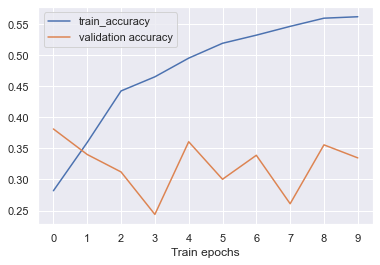

In [204]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

75/75 [==============================] - 122s 2s/step


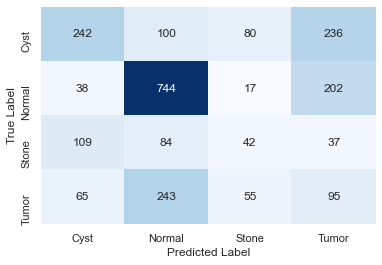

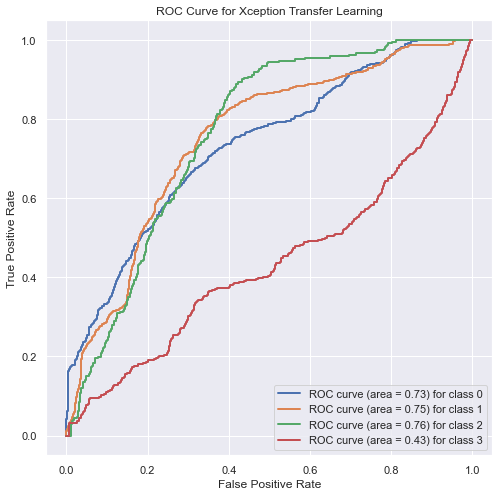

In [205]:
test_predictions = model9.predict(X_test_3_channel)
y_pred = np.argmax(test_predictions, axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

model9accuracy, model9precisions, model9recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Xception Transfer Learning')
plt.legend()
plt.show()

### Model 10 - ViT (Transfer Learning Vision Transformer)

In [194]:
# Create base model
image_size = 256
basemodel10 = vit.vit_b16(
    image_size=image_size,
    activation='relu',
    pretrained=True,
    include_top=False
    ,pretrained_top=False
#     ,classes=4
)

# Freeze base model
basemodel10.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = basemodel10(x, training = False)
# x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model10 = keras.Model(inputs, outputs)


model10.summary()

/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (256, 256, 1)             0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 dropout_4 (Dropout)         (None, 768)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               196864    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               32896 

In [196]:
model10.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
startTime = time.time()
history = model10.fit(X_train_3_channel, y_train, epochs=10, batch_size=64, 
            validation_data = (X_val_3_channel, y_val), verbose = 1)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')
model10Time = (endTime - startTime)/60

Epoch 1/10
188/188 [==============================] - 3237s 17s/step - loss: 0.6357 - accuracy: 0.7436 - val_loss: 0.9549 - val_accuracy: 0.6271
Epoch 2/10
188/188 [==============================] - 3244s 17s/step - loss: 0.3325 - accuracy: 0.8730 - val_loss: 1.2009 - val_accuracy: 0.5482
Epoch 3/10
188/188 [==============================] - 3264s 17s/step - loss: 0.2451 - accuracy: 0.9079 - val_loss: 1.2074 - val_accuracy: 0.5856
Epoch 4/10
188/188 [==============================] - 3253s 17s/step - loss: 0.2061 - accuracy: 0.9231 - val_loss: 0.8848 - val_accuracy: 0.7030
Epoch 5/10
188/188 [==============================] - 3263s 17s/step - loss: 0.1714 - accuracy: 0.9361 - val_loss: 0.9569 - val_accuracy: 0.6988
Epoch 6/10
188/188 [==============================] - 3244s 17s/step - loss: 0.1649 - accuracy: 0.9379 - val_loss: 0.8136 - val_accuracy: 0.7429
Epoch 7/10
188/188 [==============================] - 3249s 17s/step - loss: 0.1419 - accuracy: 0.9475 - val_loss: 0.9622 - val_ac

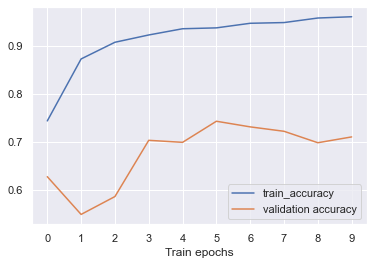

In [197]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

75/75 [==============================] - 581s 8s/step


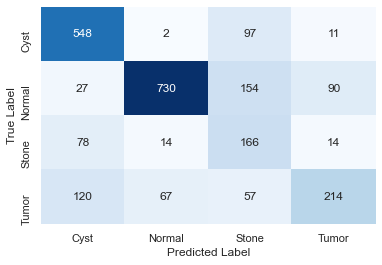

<Figure size 432x288 with 0 Axes>

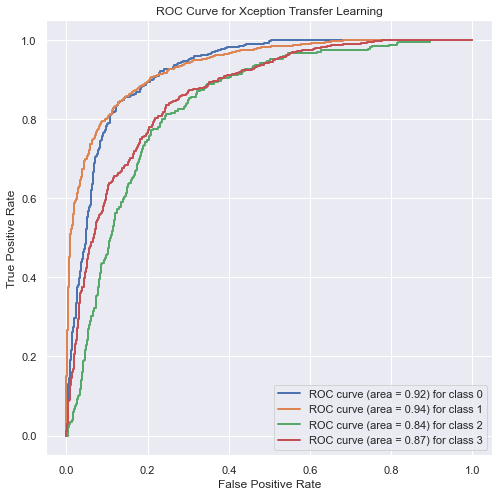

<Figure size 432x288 with 0 Axes>

In [283]:
test_predictions = model10.predict(X_test_3_channel)
y_pred = np.argmax(test_predictions, axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

model10accuracy, model10precisions, model10recalls = allClassPrecisionsandRecalls(list(y_test), list(y_pred))

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()
plt.savefig('Model10ConMatrix.png')

num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

#     Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Xception Transfer Learning')
plt.legend()
plt.show()
plt.savefig('Model10ROCCurve.png')

In [ ]:
model10accuracy, model10precisions, model10recalls

## Create a Graph of Results

In [279]:
table = [
    ['Model', 'Accuracy', 'Training Time', 'Class', 'Recall', 'Precision'],
    ['Multiclass Regression', str(round(model1accuracy*100, 2)) + '%', str(round(model1Time, 4)) + ' minutes', 'Cyst', 
             str(round(model1recalls[0]*100, 2)) + '%', 
             str(round(model1precisions[0]*100, 2)) + '%'],
    ['Multiclass Regression', str(round(model1accuracy*100, 2)) + '%', str(round(model1Time, 4)) + ' minutes', 'Normal', 
             str(round(model1recalls[1]*100, 2)) + '%', 
             str(round(model1precisions[1]*100, 2)) + '%'],
    ['Multiclass Regression', str(round(model1accuracy*100, 2)) + '%', str(round(model1Time, 4)) + ' minutes', 'Stone', 
             str(round(model1recalls[2]*100, 2)) + '%', 
             str(round(model1precisions[2]*100, 2)) + '%'],
    ['Multiclass Regression', str(round(model1accuracy*100, 2)) + '%', str(round(model1Time, 4)) + ' minutes', 'Tumor', 
             str(round(model1recalls[3]*100, 2)) + '%', 
             str(round(model1precisions[3]*100, 2)) + '%'],
    ['KNN', str(round(model2accuracy*100, 2)) + '%', str(round(model2Time, 4)) + ' minutes', 'Cyst', 
             str(round(model2recalls[0]*100, 2)) + '%', 
             str(round(model2precisions[0]*100, 2)) + '%'],
    ['KNN', str(round(model2accuracy*100, 2)) + '%', str(round(model2Time, 4)) + ' minutes', 'Normal', 
             str(round(model2recalls[1]*100, 2)) + '%', 
             str(round(model2precisions[1]*100, 2)) + '%'],
    ['KNN', str(round(model2accuracy*100, 2)) + '%', str(round(model2Time, 4)) + ' minutes', 'Stone', 
             str(round(model2recalls[2]*100, 2)) + '%', 
             str(round(model2precisions[2]*100, 2)) + '%'],
    ['KNN', str(round(model2accuracy*100, 2)) + '%', str(round(model2Time, 4)) + ' minutes', 'Tumor', 
             str(round(model2recalls[3]*100, 2)) + '%', 
             str(round(model2precisions[3]*100, 2)) + '%'],
    ['Decision Tree', str(round(model3accuracy*100, 2)) + '%', str(round(model3Time, 4)) + ' minutes', 'Cyst', 
             str(round(model3recalls[0]*100, 2)) + '%', 
             str(round(model3precisions[0]*100, 2)) + '%'],
    ['Decision Tree', str(round(model3accuracy*100, 2)) + '%', str(round(model3Time, 4)) + ' minutes', 'Normal', 
             str(round(model3recalls[1]*100, 2)) + '%', 
             str(round(model3precisions[1]*100, 2)) + '%'],
    ['Decision Tree', str(round(model3accuracy*100, 2)) + '%', str(round(model3Time, 4)) + ' minutes', 'Stone', 
             str(round(model3recalls[2]*100, 2)) + '%', 
             str(round(model3precisions[2]*100, 2)) + '%'],
    ['Decision Tree', str(round(model3accuracy*100, 2)) + '%', str(round(model3Time, 4)) + ' minutes', 'Tumor', 
             str(round(model3recalls[3]*100, 2)) + '%', 
             str(round(model3precisions[3]*100, 2)) + '%'],
    ['Neural Network', str(round(model4accuracy*100, 2)) + '%', str(round(model4Time, 4)) + ' minutes', 'Cyst', 
             str(round(model4recalls[0]*100, 2)) + '%', 
             str(round(model4precisions[0]*100, 2)) + '%'],
    ['Neural Network', str(round(model4accuracy*100, 2)) + '%', str(round(model4Time, 4)) + ' minutes', 'Normal', 
             str(round(model4recalls[1]*100, 2)) + '%', 
             str(round(model4precisions[1]*100, 2)) + '%'],
    ['Neural Network', str(round(model4accuracy*100, 2)) + '%', str(round(model4Time, 4)) + ' minutes', 'Stone', 
             str(round(model4recalls[2]*100, 2)) + '%', 
             str(round(model4precisions[2]*100, 2)) + '%'],
    ['Neural Network', str(round(model4accuracy*100, 2)) + '%', str(round(model4Time, 4)) + ' minutes', 'Tumor', 
             str(round(model4recalls[3]*100, 2)) + '%', 
             str(round(model4precisions[3]*100, 2)) + '%'],
    ['CNN Model 1', str(round(model5accuracy*100, 2)) + '%', str(round(model5Time, 4)) + ' minutes', 'Cyst', 
             str(round(model5recalls[0]*100, 2)) + '%', 
             str(round(model5precisions[0]*100, 2)) + '%'],
    ['CNN Model 1', str(round(model5accuracy*100, 2)) + '%', str(round(model5Time, 4)) + ' minutes', 'Normal', 
             str(round(model5recalls[1]*100, 2)) + '%', 
             str(round(model5precisions[1]*100, 2)) + '%'],
    ['CNN Model 1', str(round(model5accuracy*100, 2)) + '%', str(round(model5Time, 4)) + ' minutes', 'Stone', 
             str(round(model5recalls[2]*100, 2)) + '%', 
             str(round(model5precisions[2]*100, 2)) + '%'],
    ['CNN Model 1', str(round(model5accuracy*100, 2)) + '%', str(round(model5Time, 4)) + ' minutes', 'Tumor', 
             str(round(model5recalls[3]*100, 2)) + '%', 
             str(round(model5precisions[3]*100, 2)) + '%'],
    ['CNN Model 2', str(round(model6accuracy*100, 2)) + '%', str(round(model6Time, 4)) + ' minutes', 'Cyst', 
             str(round(model6recalls[0]*100, 2)) + '%', 
             str(round(model6precisions[0]*100, 2)) + '%'],
    ['CNN Model 2', str(round(model6accuracy*100, 2)) + '%', str(round(model6Time, 4)) + ' minutes', 'Normal', 
             str(round(model6recalls[1]*100, 2)) + '%', 
             str(round(model6precisions[1]*100, 2)) + '%'],
    ['CNN Model 2', str(round(model6accuracy*100, 2)) + '%', str(round(model6Time, 4)) + ' minutes', 'Stone', 
             str(round(model6recalls[2]*100, 2)) + '%', 
             str(round(model6precisions[2]*100, 2)) + '%'],
    ['CNN Model 2', str(round(model6accuracy*100, 2)) + '%', str(round(model6Time, 4)) + ' minutes', 'Tumor', 
             str(round(model6recalls[3]*100, 2)) + '%', 
             str(round(model6precisions[3]*100, 2)) + '%']
]
spans1 = []
# for i in range(1, 41, 4):
for i in range(1, 25, 4):
    for k in range(3):
        currSpan = [[j, k] for j in range(i, i+4)]
        spans1.append(currSpan)

my_spans = spans1

print(dashtable.data2rst(table, 
                         spans=my_spans, 
                         use_headers=True, 
                         center_cells=False))

+-----------------------+----------+----------------+--------+--------+-----------+
| Model                 | Accuracy | Training Time  | Class  | Recall | Precision |
+=======================+==========+================+========+========+===========+
| Multiclass Regression | 48.72%   | 4.0099 minutes | Cyst   | 36.47% | 50.85%    |
|                       |          |                +--------+--------+-----------+
|                       |          |                | Normal | 68.23% | 55.53%    |
|                       |          |                +--------+--------+-----------+
|                       |          |                | Stone  | 44.12% | 30.69%    |
|                       |          |                +--------+--------+-----------+
|                       |          |                | Tumor  | 26.42% | 40.88%    |
+-----------------------+----------+----------------+--------+--------+-----------+
| KNN                   | 38.93%   | 0.0064 minutes | Cyst   | 55.62% | 37.2

In [280]:
table = [
    ['Model', 'Accuracy', 'Training Time', 'Class', 'Recall', 'Precision'],
    ['Random Forrest', str(round(model7accuracy*100, 2)) + '%', str(round(model7Time, 4)) + ' minutes', 'Cyst', 
             str(round(model7recalls[0]*100, 2)) + '%', 
             str(round(model7precisions[0]*100, 2)) + '%'],
    ['Random Forrest', str(round(model7accuracy*100, 2)) + '%', str(round(model7Time, 4)) + ' minutes', 'Normal', 
             str(round(model7recalls[1]*100, 2)) + '%', 
             str(round(model7precisions[1]*100, 2)) + '%'],
    ['Random Forrest', str(round(model7accuracy*100, 2)) + '%', str(round(model7Time, 4)) + ' minutes', 'Stone', 
             str(round(model7recalls[2]*100, 2)) + '%', 
             str(round(model7precisions[2]*100, 2)) + '%'],
    ['Random Forrest', str(round(model7accuracy*100, 2)) + '%', str(round(model7Time, 4)) + ' minutes', 'Tumor', 
             str(round(model7recalls[3]*100, 2)) + '%', 
             str(round(model7precisions[3]*100, 2)) + '%'],
    ['XGBoost', str(round(model8accuracy*100, 2)) + '%', str(round(model8Time, 4)) + ' minutes', 'Cyst', 
             str(round(model8recalls[0]*100, 2)) + '%', 
             str(round(model8precisions[0]*100, 2)) + '%'],
    ['XGBoost', str(round(model8accuracy*100, 2)) + '%', str(round(model8Time, 4)) + ' minutes', 'Normal', 
             str(round(model8recalls[1]*100, 2)) + '%', 
             str(round(model8precisions[1]*100, 2)) + '%'],
    ['XGBoost', str(round(model8accuracy*100, 2)) + '%', str(round(model8Time, 4)) + ' minutes', 'Stone', 
             str(round(model8recalls[2]*100, 2)) + '%', 
             str(round(model8precisions[2]*100, 2)) + '%'],
    ['XGBoost', str(round(model8accuracy*100, 2)) + '%', str(round(model8Time, 4)) + ' minutes', 'Tumor', 
             str(round(model8recalls[3]*100, 2)) + '%', 
             str(round(model8precisions[3]*100, 2)) + '%'],
    ['Xception Transfer Learning', str(round(model9accuracy*100, 2)) + '%', str(round(model9Time, 4)) + ' minutes', 'Cyst', 
             str(round(model9recalls[0]*100, 2)) + '%', 
             str(round(model9precisions[0]*100, 2)) + '%'],
    ['Xception Transfer Learning', str(round(model9accuracy*100, 2)) + '%', str(round(model9Time, 4)) + ' minutes', 'Normal', 
             str(round(model9recalls[1]*100, 2)) + '%', 
             str(round(model9precisions[1]*100, 2)) + '%'],
    ['Xception Transfer Learning', str(round(model9accuracy*100, 2)) + '%', str(round(model9Time, 4)) + ' minutes', 'Stone', 
             str(round(model9recalls[2]*100, 2)) + '%', 
             str(round(model9precisions[2]*100, 2)) + '%'],
    ['Xception Transfer Learning', str(round(model9accuracy*100, 2)) + '%', str(round(model9Time, 4)) + ' minutes', 'Tumor', 
             str(round(model9recalls[3]*100, 2)) + '%', 
             str(round(model9precisions[3]*100, 2)) + '%'],
    ['ViT Transfer Learning', str(round(model10accuracy*100, 2)) + '%', str(round(model10Time, 4)) + ' minutes', 'Cyst', 
             str(round(model10recalls[0]*100, 2)) + '%', 
             str(round(model10precisions[0]*100, 2)) + '%'],
    ['ViT Transfer Learning', str(round(model10accuracy*100, 2)) + '%', str(round(model10Time, 4)) + ' minutes', 'Normal', 
             str(round(model10recalls[1]*100, 2)) + '%', 
             str(round(model10precisions[1]*100, 2)) + '%'],
    ['ViT Transfer Learning', str(round(model10accuracy*100, 2)) + '%', str(round(model10Time, 4)) + ' minutes', 'Stone', 
             str(round(model10recalls[2]*100, 2)) + '%', 
             str(round(model10precisions[2]*100, 2)) + '%'],
    ['ViT Transfer Learning', str(round(model10accuracy*100, 2)) + '%', str(round(model10Time, 4)) + ' minutes', 'Tumor', 
             str(round(model10recalls[3]*100, 2)) + '%', 
             str(round(model10precisions[3]*100, 2)) + '%']
]
spans1 = []
# for i in range(1, 41, 4):
for i in range(1, 17, 4):
    for k in range(3):
        currSpan = [[j, k] for j in range(i, i+4)]
        spans1.append(currSpan)

my_spans = spans1

print(dashtable.data2rst(table, 
                         spans=my_spans, 
                         use_headers=True, 
                         center_cells=False))

+----------------------------+----------+------------------+--------+--------+-----------+
| Model                      | Accuracy | Training Time    | Class  | Recall | Precision |
+============================+==========+==================+========+========+===========+
| Random Forrest             | 58.89%   | 0.1438 minutes   | Cyst   | 86.63% | 52.92%    |
|                            |          |                  +--------+--------+-----------+
|                            |          |                  | Normal | 68.23% | 81.02%    |
|                            |          |                  +--------+--------+-----------+
|                            |          |                  | Stone  | 13.97% | 21.35%    |
|                            |          |                  +--------+--------+-----------+
|                            |          |                  | Tumor  | 25.33% | 39.86%    |
+----------------------------+----------+------------------+--------+--------+-----------+